# Assignment 2
### Daniel Tan (22684196)

##  1. Breast Cancer Wisconsin Dataset

Here, we train a few decision tree classifiers on the Breast Cancer dataset and compare their performances.

In [56]:
import sys
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
bc = load_breast_cancer()
bc_X, bc_y = load_breast_cancer(return_X_y=True, as_frame=True)
print("The format (shape) of feature matrix X is {} and class vector has {} elements".format(bc_X.shape, bc_y.shape))

The format (shape) of feature matrix X is (569, 30) and class vector has (569,) elements


Investigate whether some features can be dropped through suitable visualisation of the data. For instance, if 2 features have a linear relationship, then it would be sufficient to keep only one of these features. Therefore, we can assess for the classification task later on so it will not be too difficult.

Since there are 30 variables, we test them by sets of 10

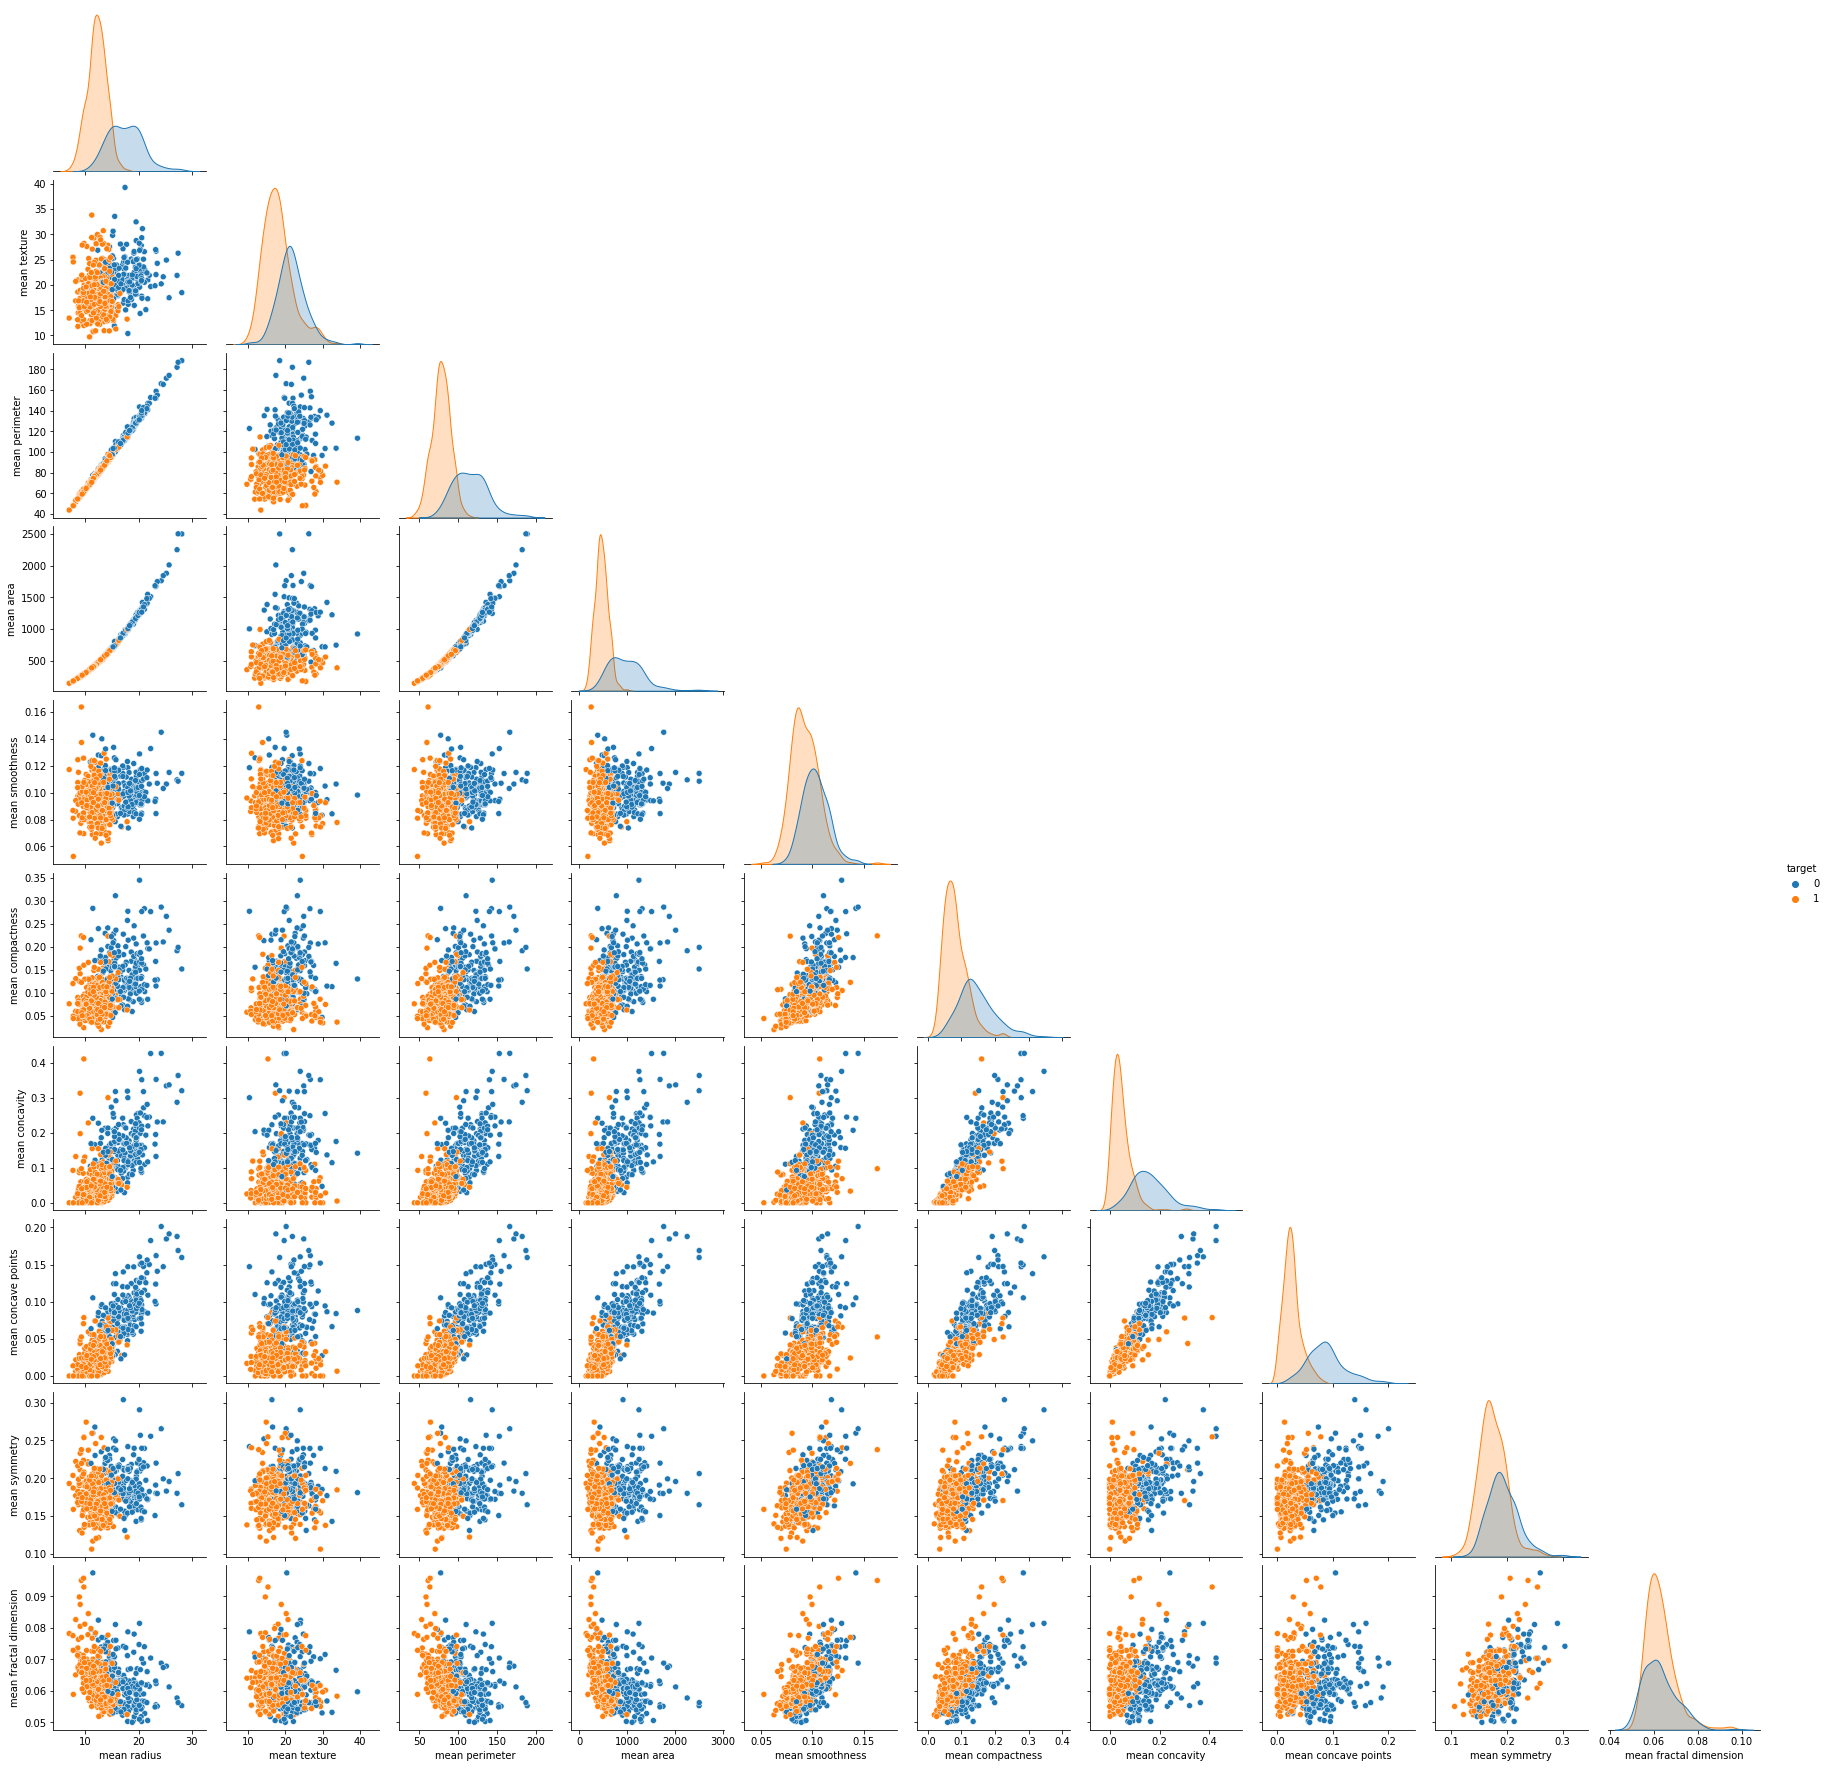

In [3]:
data10 = pd.concat([bc_X.iloc[:,0:10], bc_y], axis=1)
sns.pairplot(data10, diag_kind = 'kde', hue='target',corner=True)

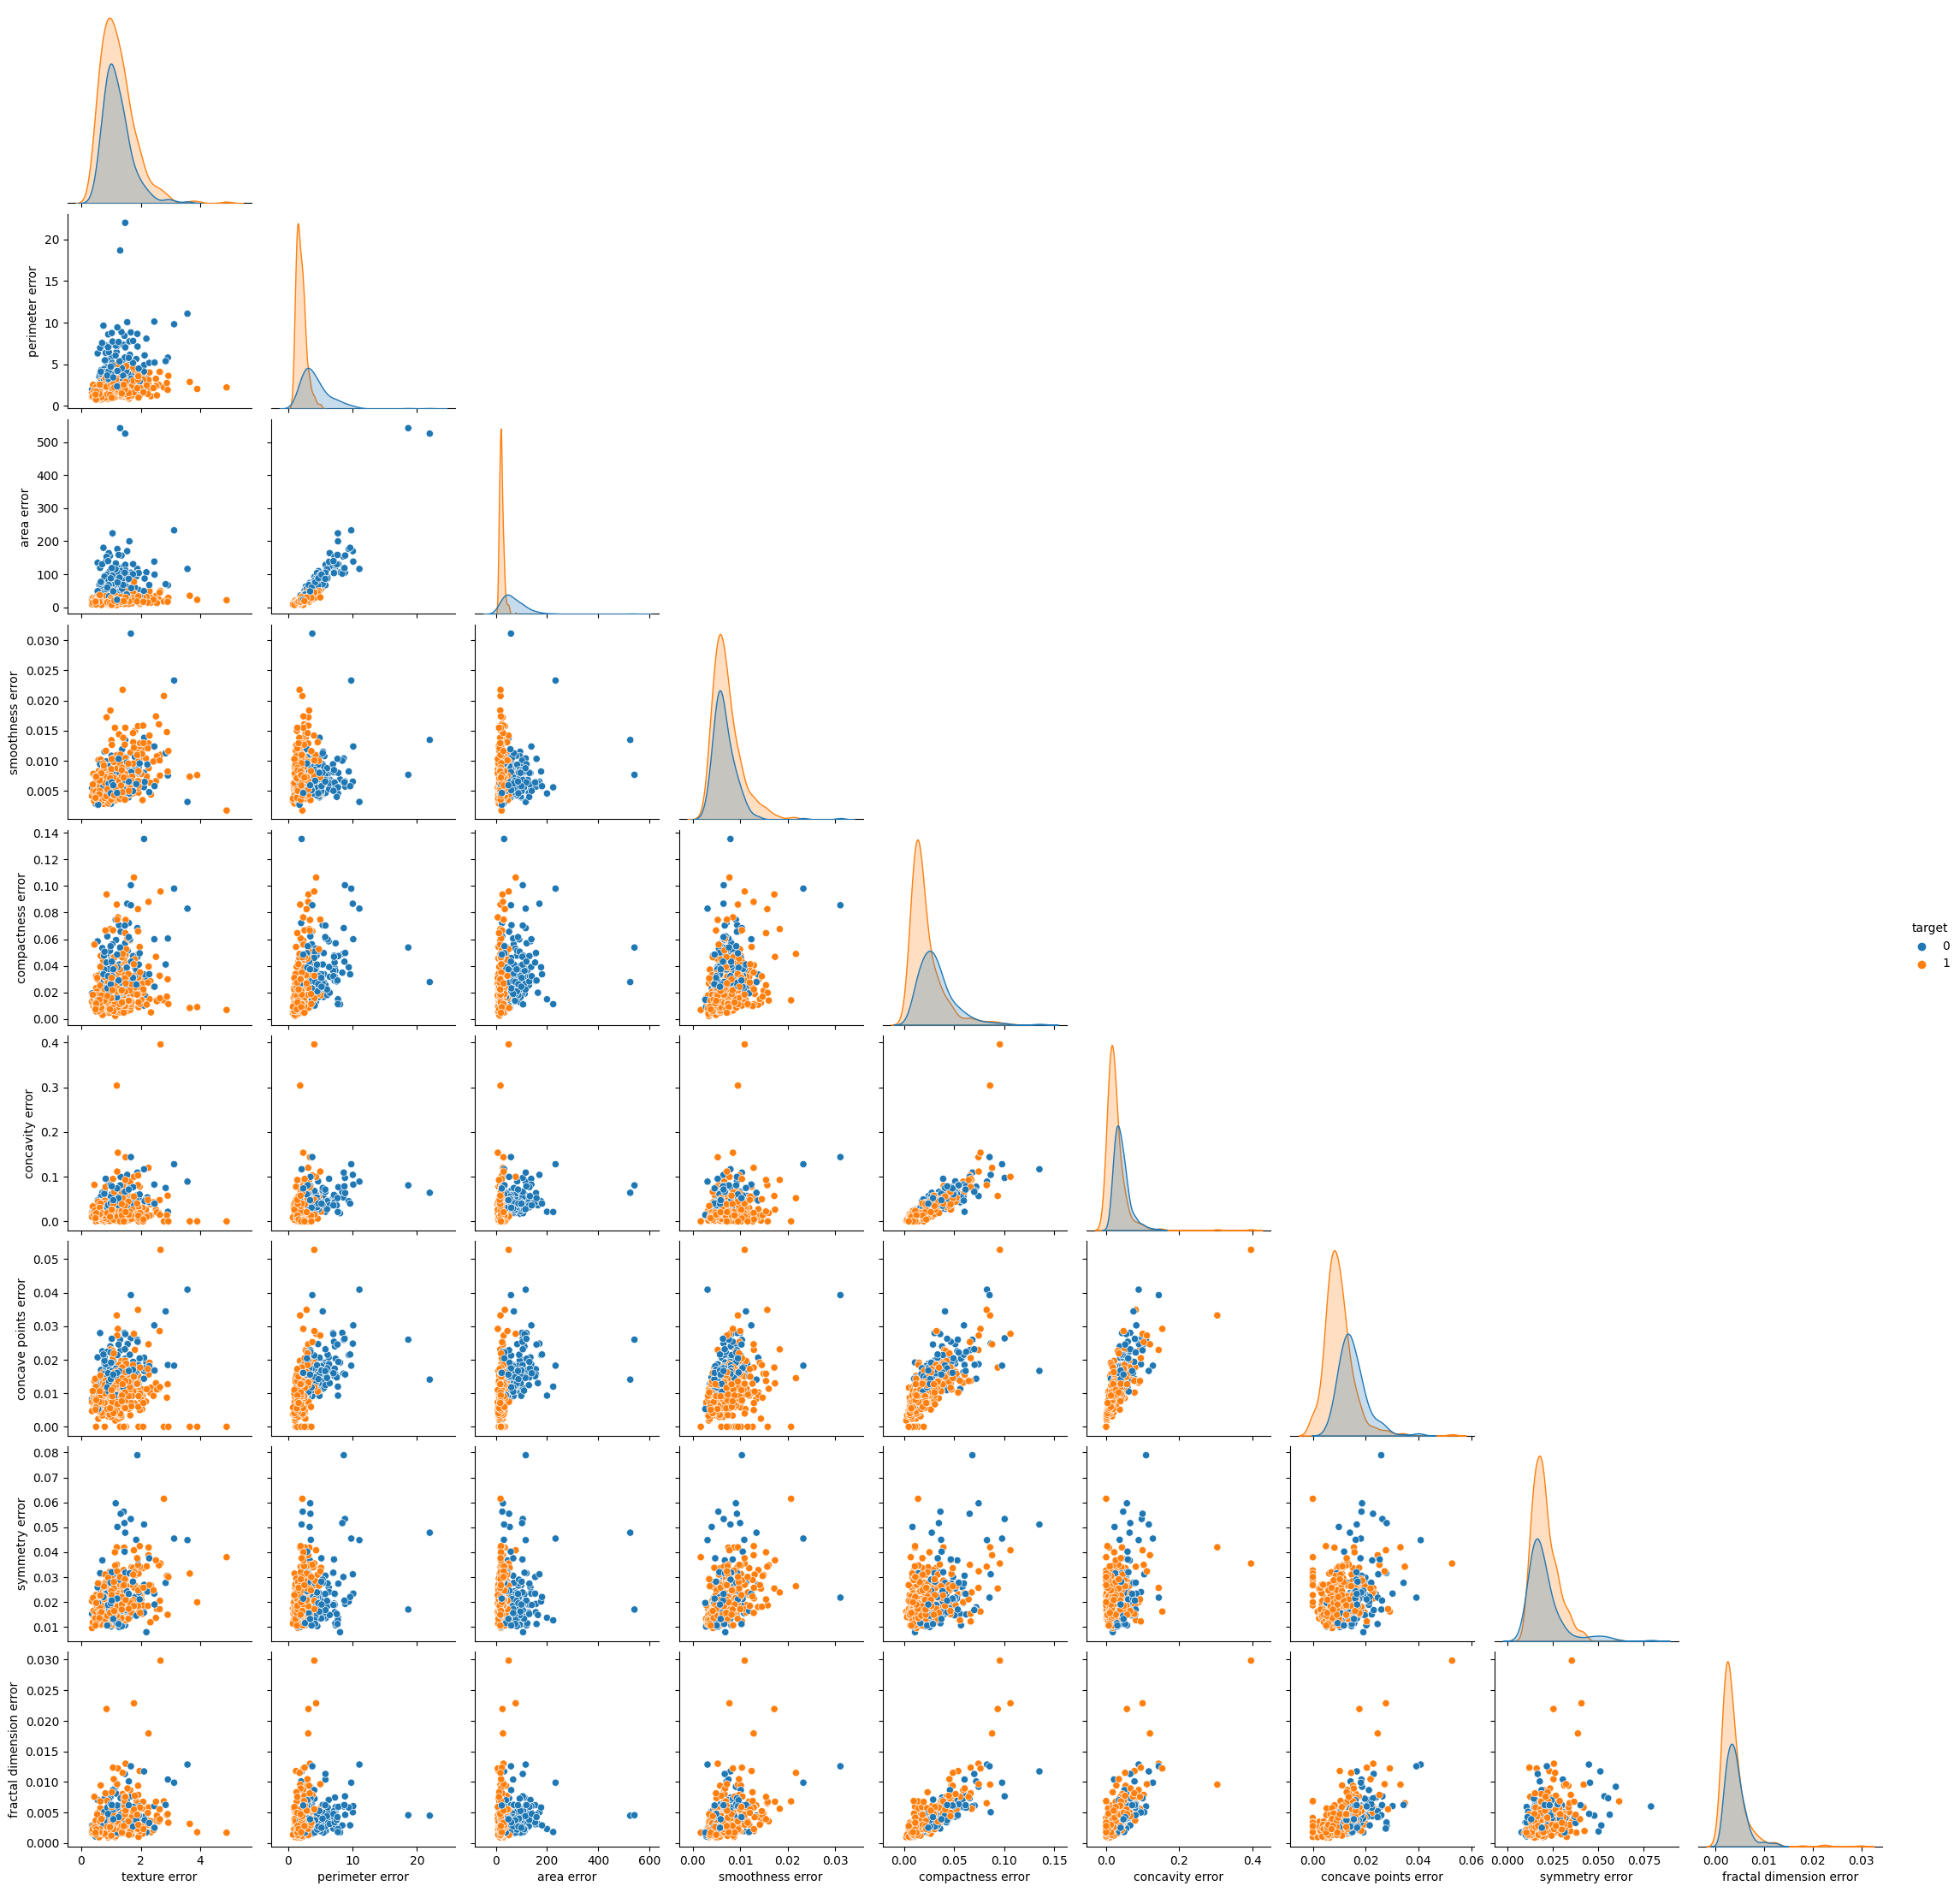

In [67]:
data20 = pd.concat([bc_X.iloc[:,11:20], bc_y], axis=1)
sns.pairplot(data20, diag_kind = 'kde', hue='target',corner=True)

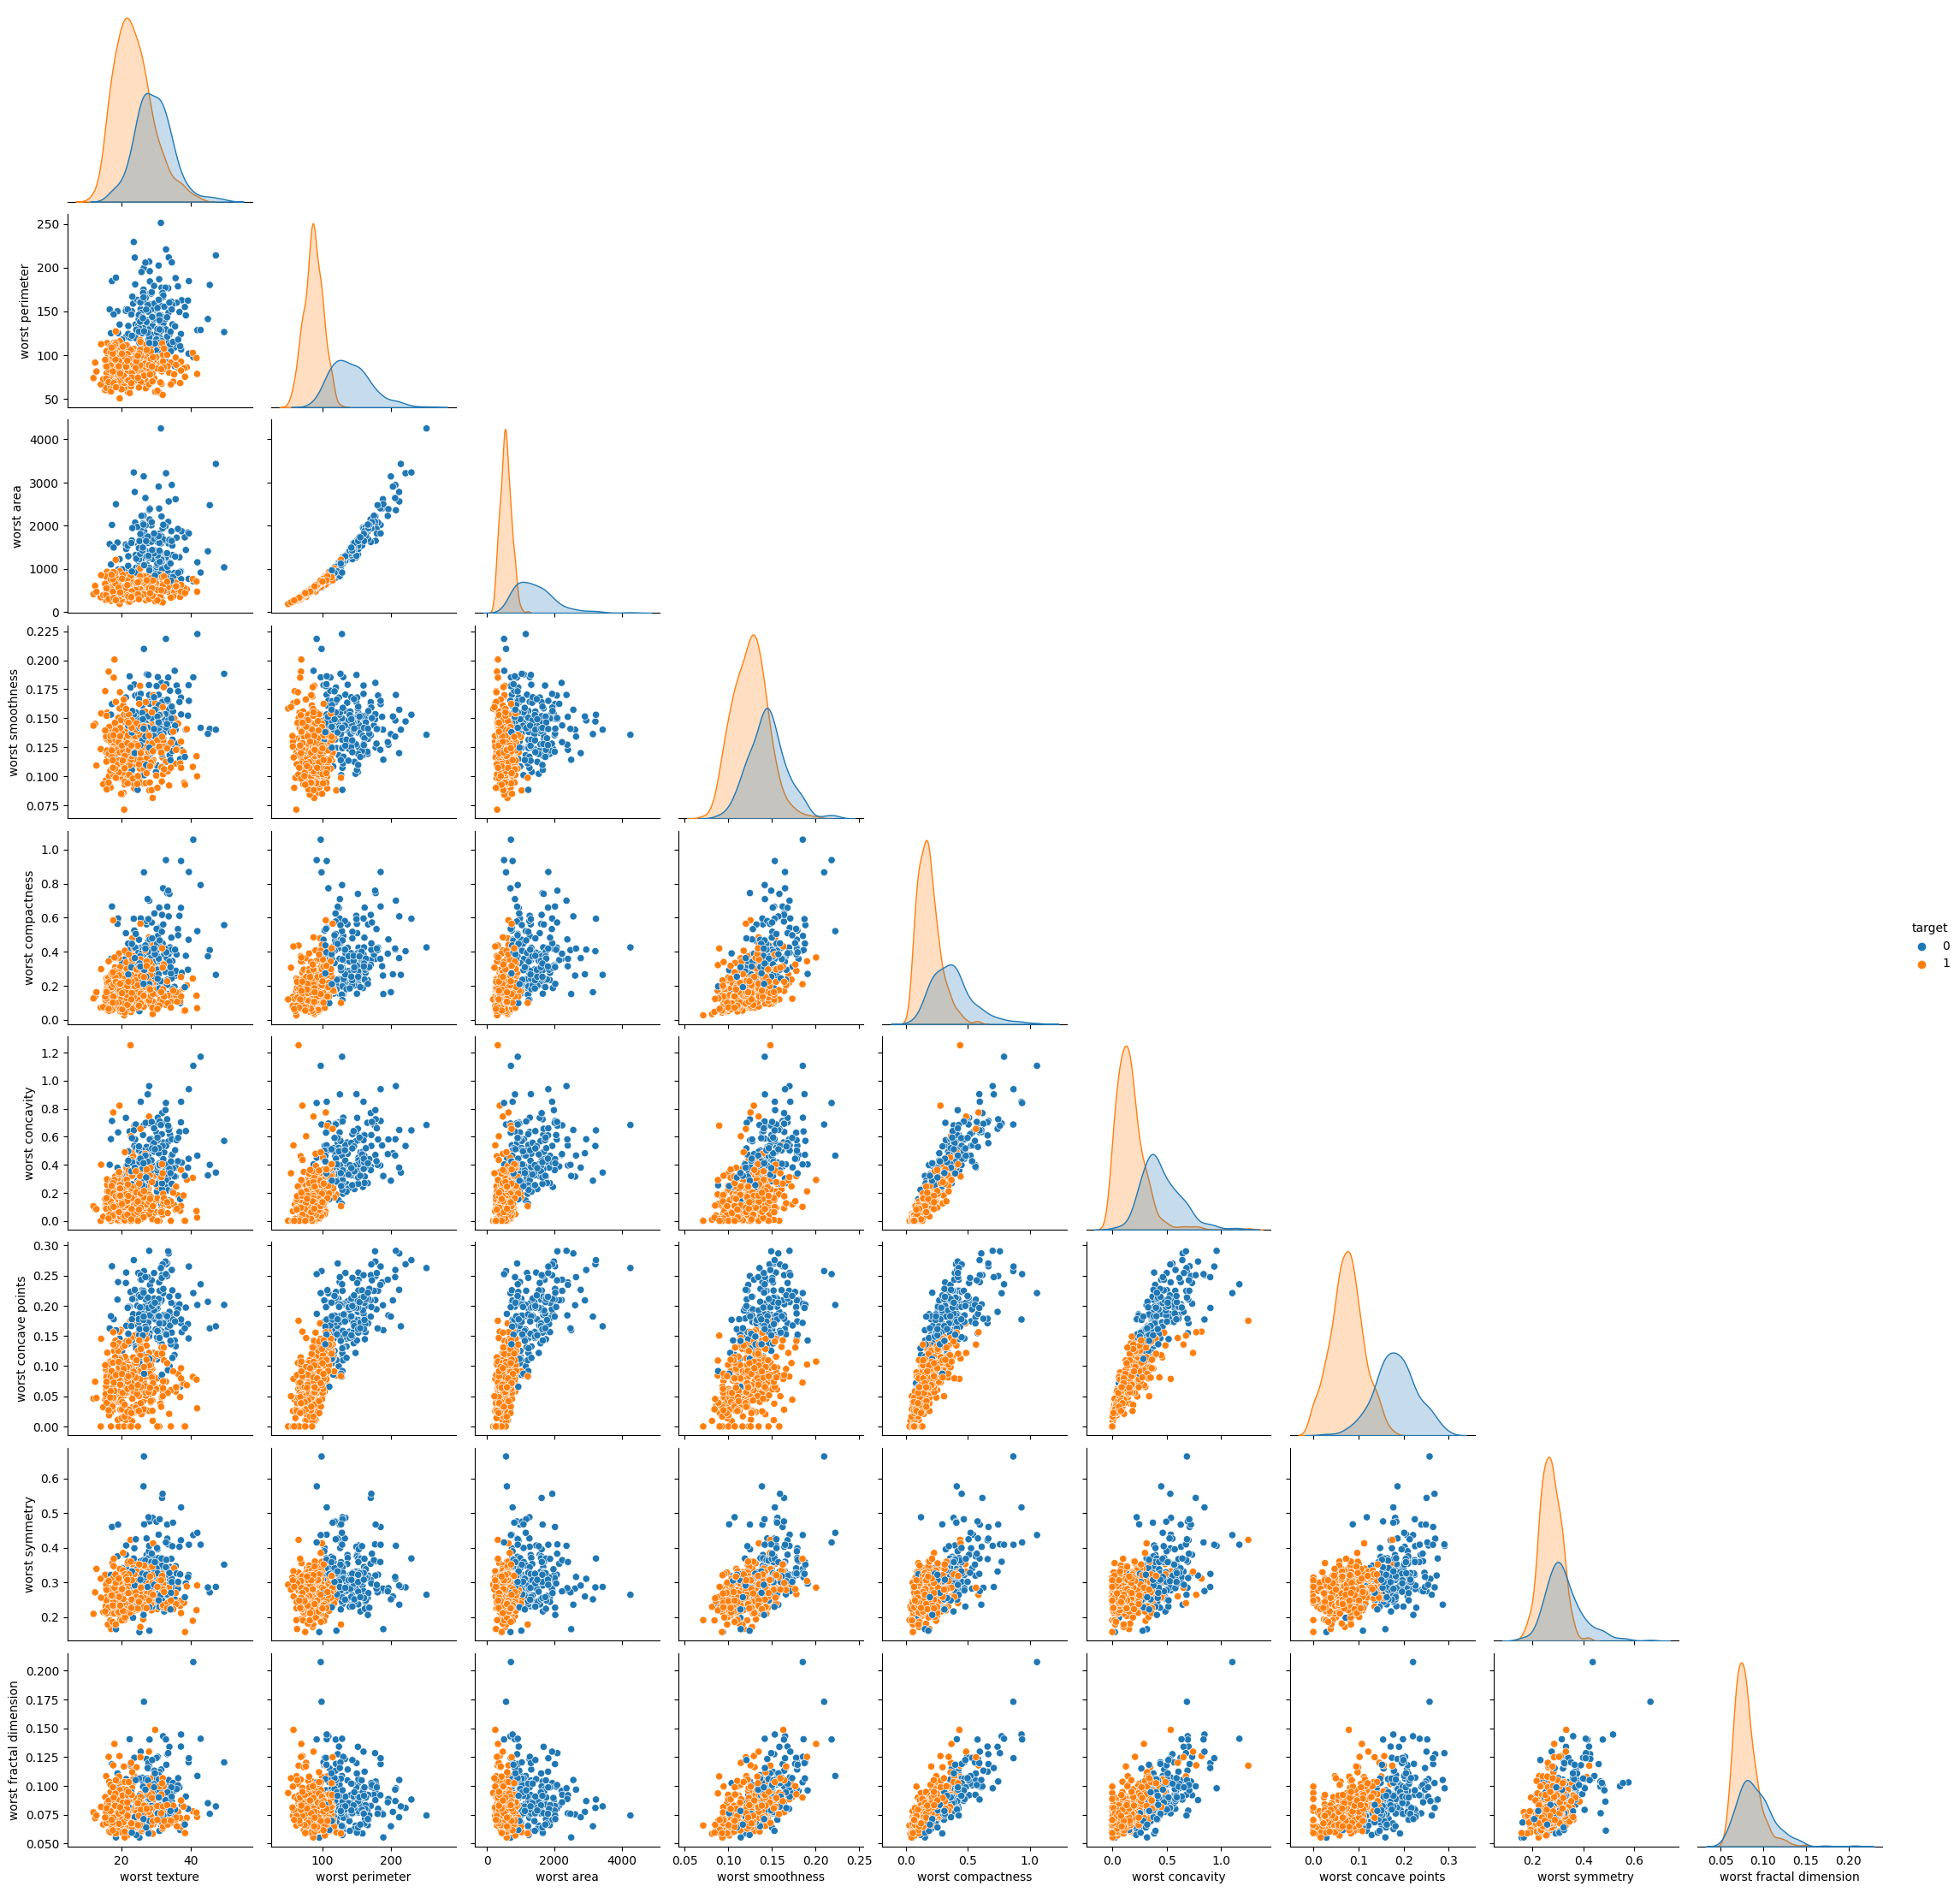

In [68]:
data30 = pd.concat([bc_X.iloc[:,21:30], bc_y], axis=1)
sns.pairplot(data30, diag_kind = 'kde', hue='target',corner=True)

Upon looking at the scatterplot of the first 10 covariates, followed by the next 10 and the last 10, we observe that there are some pairs show a clear linear relationship and also a clear seperation of the classes (target 0 and 1).

From the visualisation, because we have a quite large number of covariates, perhaps it would be better if we use some correlation score to help us identify the pairs of covariates that are highly correlated to each other, given a threshold score of 0.9. 

In [6]:
def correlation_pairs(data_X, threshold=0.85):
    corrmatrix = data_X.corr().abs() # get correlation matrix
    np.fill_diagonal(corrmatrix.values, 0) # remove the diag 1s
    
    # retrive highly correlated pairs
    corrpairs = []
    for pair1 in bc_X.columns:
        for pair2 in bc_X.columns:
            if corrmatrix.loc[pair1,pair2] > threshold: # if meets the threshold, show the pair
                corrpairs.append((pair1,pair2))
                
    drop_features = []
    for f1, f2 in corrpairs:
        if f1 not in drop_features and f2 not in drop_features:
            drop_features.append(f2)
    return drop_features

In [7]:
redundant_features = correlation_pairs(bc_X)
redundant_features

['mean perimeter',
 'mean area',
 'worst radius',
 'worst perimeter',
 'worst area',
 'worst texture',
 'mean concavity',
 'worst compactness',
 'worst concave points',
 'perimeter error',
 'area error']

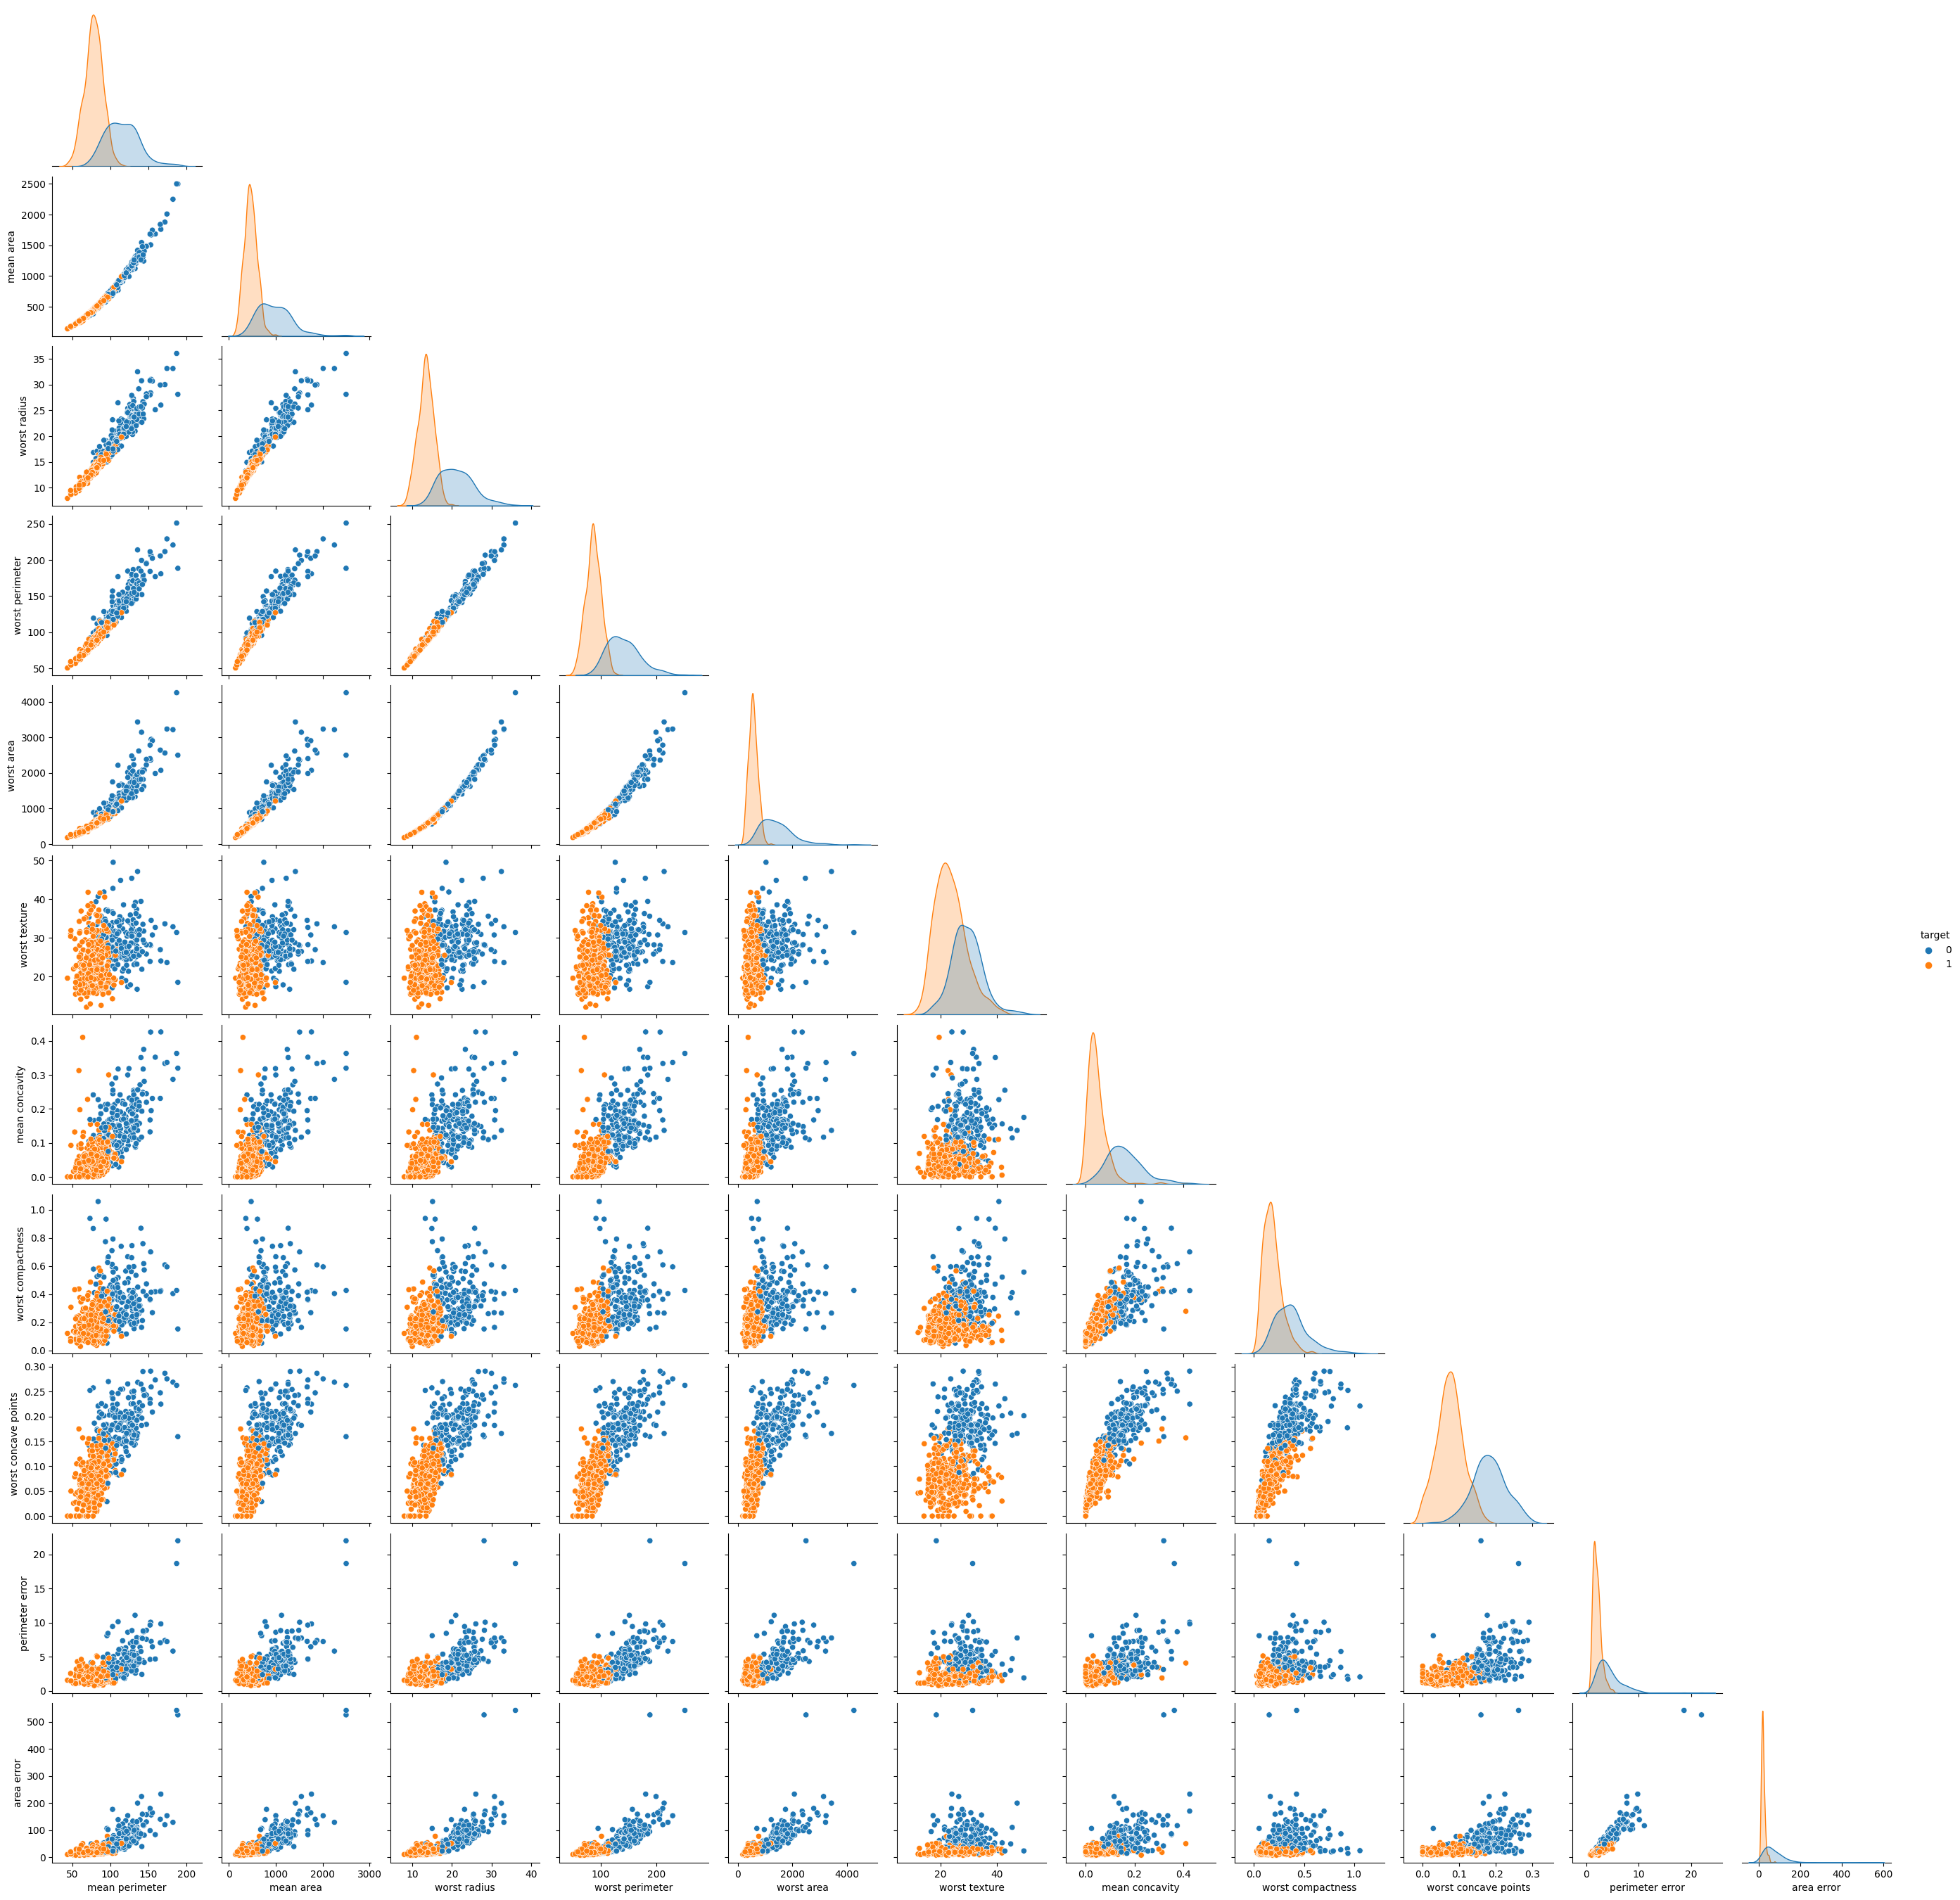

In [8]:
# show the pairs plot of the redundant features
data_rf = pd.concat([bc_X.loc[:,redundant_features], bc_y], axis=1)
sns.pairplot(data_rf, diag_kind = 'kde', hue='target',corner=True)

As expected, we see the pairs plot of the features that we identified to be correlated to one another with good class seperation, so we can remove all of them except 1, which will be mean perimeter.

In [9]:
# keeping the mean perimeter variable and dropping the rest
redundant_features[1:]

['mean area',
 'worst radius',
 'worst perimeter',
 'worst area',
 'worst texture',
 'mean concavity',
 'worst compactness',
 'worst concave points',
 'perimeter error',
 'area error']

In [10]:
bc_X_dropped = bc_X.drop(columns=redundant_features[1:])
bc_X_dropped.shape # we dropped 10 variables

(569, 20)

We can then now proceed to split the training and the test set into a 85/15 ratio.

In [11]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test
train_X, test_X, train_Y, test_Y = train_test_split(bc_X_dropped, bc_y, test_size = 0.15, random_state=123)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((483, 20), (86, 20), (483,), (86,))

**Decision Tree Classifier**

1. Train a Decision Tree Classifier using all the default values for all the hyperparameters

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
# default values for all the hyperparams
tree_clf_first = DecisionTreeClassifier(random_state=5508)
tree_clf_first.fit(train_X.values, train_Y)

DecisionTreeClassifier(random_state=5508)

We then use the model, with all default hyperparameters to perform predictions on the training set and the test set.

In [26]:
from sklearn.metrics import accuracy_score

# create a function to calculate the accuracy score
def calculate_accuracy(model, dataset, actual):
    pred = model.predict(dataset.values)
    train_score = accuracy_score(actual, pred)
    return(train_score)

def train_test_acc(model, train_X, trainY, testX, testY):
    train_acc = calculate_accuracy(model, train_X, trainY)
    test_acc = calculate_accuracy(model, testX, testY)
    print('Training accuracy: {}'.format(train_acc))
    print('Test accuracy: {}'.format(test_acc))

train_test_acc(tree_clf_first, train_X, train_Y, test_X, test_Y)

Training accuracy: 1.0
Test accuracy: 0.9069767441860465


Looking at the accuracy score of the model fit, we can see that for the training set, it achieved a perfect score, compared to the test set accuracy, which is about 88%, showing quite a significant difference between the 2 scores. This might be a sign of the decision tree classifier being overfitted, capturing the variation/noise in the data.

Because we used the default hyperparameters, where max_depth is not specified, meaning that the tree could be built all leaves are pure or until all leaves contain less than min_samples_split samples, which is default 2, then there is a good chance we have overfitted the training data, and we want to generalise the model by perhaps pruning it (adjusting the hyperparameter of max_depth to a value, but not underfitting the tree)

In [27]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

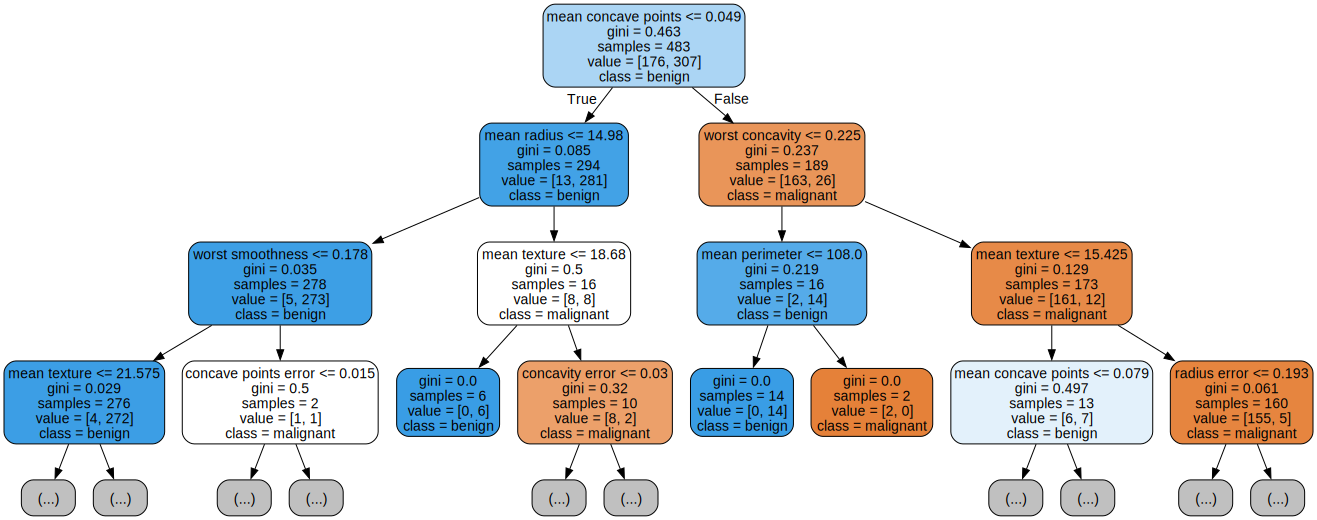

In [28]:
from graphviz import Source
from sklearn.tree import export_graphviz

# Generating a visual on the tree model:
export_graphviz(
        tree_clf_first,
        out_file=os.path.join(IMAGES_PATH, "tree_clf_first.dot"),
        feature_names=train_X.columns,
        class_names=load_breast_cancer().target_names,
        rounded=True,
        filled=True,
        max_depth=3,
    )

Source.from_file(os.path.join(IMAGES_PATH, "tree_clf_first.dot"))

In [29]:
tree_clf_first.get_depth(), tree_clf_first.get_n_leaves()

(8, 23)

Training accuracy is perfect, might be an indication of a overfitting issue. We also observe that the tree depth is 8, and the number of leaves is 23, which in both cases, can be considered quite high. 

**Decision Tree Classifier II**

In [30]:
# Construct a second DT classifier by setting the hyperparameter to max_depth=3, and calculate the accuracy scores
tree_clf_second = DecisionTreeClassifier(max_depth=3, random_state=5508)
tree_clf_second.fit(train_X.values, train_Y)
train_test_acc(tree_clf_second, train_X, train_Y, test_X, test_Y)

Training accuracy: 0.9627329192546584
Test accuracy: 0.9302325581395349


Seems like the test accuracy does slightly better than the default model, so this decision tree with the max_depth=3, where the tree has been cut generalises better, and less signs of overfitting.

**Decision Tree Classifier III**

In [32]:
# Construct a third DT classifier by adding the min_samples_split, and calculate the accuracy scores
tree_clf_third = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=5508)
tree_clf_third.fit(train_X.values, train_Y)
train_test_acc(tree_clf_third, train_X, train_Y, test_X, test_Y)

Training accuracy: 0.9627329192546584
Test accuracy: 0.9302325581395349


Returns the same accuracy for both the training and test as the second fir with just the max_depth tuned, does better than the base model.

**Decision Tree Classifier IV**

In [34]:
tree_clf_fourth = DecisionTreeClassifier(max_depth=3, min_samples_split=5, min_samples_leaf=5, random_state=5508)
tree_clf_fourth.fit(train_X.values, train_Y)
train_test_acc(tree_clf_fourth, train_X, train_Y, test_X, test_Y)

Training accuracy: 0.9585921325051759
Test accuracy: 0.9302325581395349


Training accuracy is slightly worse, but test accuracy is the same as the last 2 beforehand.

**3 Fold CV and Grid Search**
We want to find the best combination of these hyperparameters on the training set.

In [35]:
from sklearn.model_selection import GridSearchCV

# define the paramters to be searched for the decision tree
grid_params = {'max_depth':np.arange(2,10,1),
               'min_samples_split':np.arange(2,10,1),
               'min_samples_leaf':np.arange(2,10,1)} 

# default values for all the hyperparams
tree_clf = DecisionTreeClassifier(random_state=123)
grid_search = GridSearchCV(tree_clf, grid_params, cv=3)
grid_search.fit(train_X.values, train_Y)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])})

In [36]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score

({'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2},
 0.9296066252587991)

In [37]:
optim_max_depth = best_params['max_depth']
optim_min_leaf = best_params['min_samples_leaf']
optim_min_split = best_params['min_samples_split']

**Best Hyperparameters**

In [40]:
# Using the best combination of hyperparameters using the grid search CV=3 to train the optimal model
tree_clf_optimal = DecisionTreeClassifier(max_depth=optim_max_depth, 
                                          min_samples_split=optim_min_split, 
                                          min_samples_leaf=optim_min_leaf,
                                          random_state=5508)
tree_clf_optimal.fit(train_X.values, train_Y)
train_test_acc(tree_clf_optimal, train_X, train_Y, test_X, test_Y)

Training accuracy: 0.9834368530020704
Test accuracy: 0.9302325581395349


Comparing the model with the optimal hyperparameters, we can see that for the test accuracy, it is the same as the previous models, but the training accuracy is alot higher. We also observe that the base model with no tuning gives us a higher accuracy for the training set and lower accuracy for the test set than this, which might signal overfitting. Therefore, we pick the model with the best hyperparameters, as it might be able to generalise the data better and avoid overfitting but still give us a good prediction at the end.

In [44]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
# Confusion Matrix
y_pred_test = tree_clf_optimal.predict(test_X.values)
y_pred_train = tree_clf_optimal.predict(train_X.values)

In [45]:
def performance_metrics(test_pred, test_y, train_pred, train_y):
    ps_train, ps_test = precision_score(train_pred,train_y, pos_label=1), precision_score(test_pred,test_y, pos_label=1)
    rc_train, rc_test = recall_score(train_pred,train_y, pos_label=1), recall_score(test_pred,test_y, pos_label=1)
    f1_train, f1_test = f1_score(train_pred,train_y, pos_label=1), f1_score(test_pred,test_y, pos_label=1)
    acc_train, acc_test = accuracy_score(train_pred,train_y), accuracy_score(test_pred,test_y)
    
    metrics = {'Metric': ['Precision', 'Recall', 'F1 score', 'Accuracy'],
               'Train score': [ps_train, rc_train, f1_train, acc_train],
               'Test score': [ps_test, rc_test, f1_test, acc_test]}
    
    # create a DataFrame from the dictionary
    scores = pd.DataFrame(metrics).set_index('Metric')
    
    return(scores)

Th tables below shows the 3 fold CV decision tree of the best hyperparamters, for the training and the test set.

In [46]:
performance_metrics(y_pred_test, test_Y, y_pred_train, train_Y)

Train score  Test score
Metric                            
Precision     0.986971    0.940000
Recall        0.986971    0.940000
F1 score      0.986971    0.940000
Accuracy      0.983437    0.930233

In the case of the breast cancer dataset, where we are dealing with diagnosing a sickeness, it is of utmost importance that we classify and get an accurate prediction on whether the tumour/cancer is malignant or benign. Given the situation, we would want a very high recall score on our model, to correctly identify patients that have cancer to be able to treat them early. Also, it is also important that we do not misclassify healthy patients as sick, and then put them through treatment, so we also aim for a good precision score.

However, the precision-recall score tradeoff exists. Therefore, perhaps we would want to assign more importance into keeping the recall score as high as possible in this case.

## 2. Concrete Slump Test

We aim to predict the 28-day Compressive Strength (MPA) value, using the train model on the other 7 feature variables.

**Loading and Inspecting the Data**

In [75]:
# remember to change to the same directory
slump_data = pd.read_csv("../datasets/slump_test.data")
slump_data

No  Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  \
0      1   273.0   82.0    105.0  210.0   9.0         904.0       680.0   
1      2   163.0  149.0    191.0  180.0  12.0         843.0       746.0   
2      3   162.0  148.0    191.0  179.0  16.0         840.0       743.0   
3      4   162.0  148.0    190.0  179.0  19.0         838.0       741.0   
4      5   154.0  112.0    144.0  220.0  10.0         923.0       658.0   
..   ...     ...    ...      ...    ...   ...           ...         ...   
98    99   248.3  101.0    239.1  168.9   7.7         954.2       640.6   
99   100   248.0  101.0    239.9  169.1   7.7         949.9       644.1   
100  101   258.8   88.0    239.6  175.3   7.6         938.9       646.0   
101  102   297.1   40.9    239.9  194.0   7.5         908.9       651.8   
102  103   348.7    0.1    223.1  208.5   9.6         786.2       758.1   

     SLUMP(cm)  FLOW(cm)  Compressive Strength (28-day)(Mpa)  
0         23.0      62.0                               34.99  
1          0.0      20.0                               41.14  
2          1.0      20.0                               41.81  
3          3.0      21.5                               42.08  
4         20.0      64.0                               26.82  
..         ...       ...                                 ...  
98         0.0      20.0                               49.97  
99         2.0      20.0                               50.23  
100        0.0      20.0                               50.50  
101       27.5      67.0                               49.17  
102       29.0      78.0                               48.77  

[103 rows x 11 columns]

In [76]:
# Check for any missing values in the dataset
null_count = np.array(slump_data.isnull().sum())
na_counts = np.array(slump_data.isna().sum())
pd.DataFrame(np.vstack((null_count, na_counts)), columns=slump_data.columns, index=['null_count','na_counts'])

No  Cement  Slag  Fly ash  Water  SP  Coarse Aggr.  Fine Aggr.  \
null_count   0       0     0        0      0   0             0           0   
na_counts    0       0     0        0      0   0             0           0   

            SLUMP(cm)  FLOW(cm)  Compressive Strength (28-day)(Mpa)  
null_count          0         0                                   0  
na_counts           0         0                                   0

Looks like our data is clean, with no NA or null values, so no need to impute or remove any rows. However, we do want to partition the dataset to include only the columns that are relevant to us. The columns to drop are:
- No (Index)
- SLUMP
- FLOW

A visual inspection of the dataset allows us to identify what index the columns are and remove them

In [77]:
# Take the first 7, excluding the index and the last dependent variable
def data_selection(dataset):
    X = dataset.iloc[:,1:8]
    y = dataset.iloc[:,-1]
    return(X,y)

X,y = data_selection(slump_data)

# Splitting the dataset into a training set and a test set of 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5508)

**Voting Regressor - Linear SVM Regressor, LinReg, SGD Regressor**

Before we proceed, because we are using a SVM method, we require scaling on the data before proceeding to fit any regression models.

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
std_scaler = StandardScaler() # call the scaler function

num_pipeline = Pipeline([ # pipeline for scaling the data
    ('std_scaler', StandardScaler())
])

In [79]:
# scale the data first
X_train_scaled = pd.DataFrame(num_pipeline.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(num_pipeline.fit_transform(X_test), columns=X_train.columns)

In [118]:
from sklearn.ensemble import VotingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error

# call the regression models, then put them into the voting regressor
lin_svr = LinearSVR()
lin_reg = LinearRegression()
sgd_reg = SGDRegressor()

voting_reg = VotingRegressor(estimators=[
    ('Linear SVM', LinearSVR()),
    ('Linear Regression', LinearRegression()),
    ('SGD Regression', SGDRegressor())
])

In [119]:
np.random.seed(5508)
# train the models, get both train and test RMSE
base_test_rsme = []
for reg in (lin_svr, lin_reg, sgd_reg, voting_reg):
    reg.fit(X_train_scaled, y_train)
    y_pred_train = reg.predict(X_train_scaled)
    y_pred_test = reg.predict(X_test_scaled)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    base_test_rsme.append(rmse_test)
    print(f'{reg.__class__.__name__} - RMSE train: {rmse_train}, RMSE test: {rmse_test}')

LinearSVR - RMSE train: 2.8571086002708794, RMSE test: 3.339646492009573
LinearRegression - RMSE train: 2.3520029517363343, RMSE test: 3.534364825114908
SGDRegressor - RMSE train: 2.3550422325832954, RMSE test: 3.487518263072861
VotingRegressor - RMSE train: 2.4157808997571326, RMSE test: 3.3604607760222205


RMSE between the 4 regression models, show not much difference between them. The voting regressor, which is supposed to provide a more accurate prediciton, which takes the average of the 3 models, which improves the generalisability of the models. However, we can see that the RMSE of the Voting Regressor is not the best out of the 4, with the Linear SVR having a lower score.

In [120]:
# get predicted values for all 4 models
pred_lin_svr = lin_svr.predict(X_test_scaled)
pred_lin_reg = lin_reg.predict(X_test_scaled)
pred_sgd_reg = sgd_reg.predict(X_test_scaled)
pred_voting_reg = voting_reg.predict(X_test_scaled)

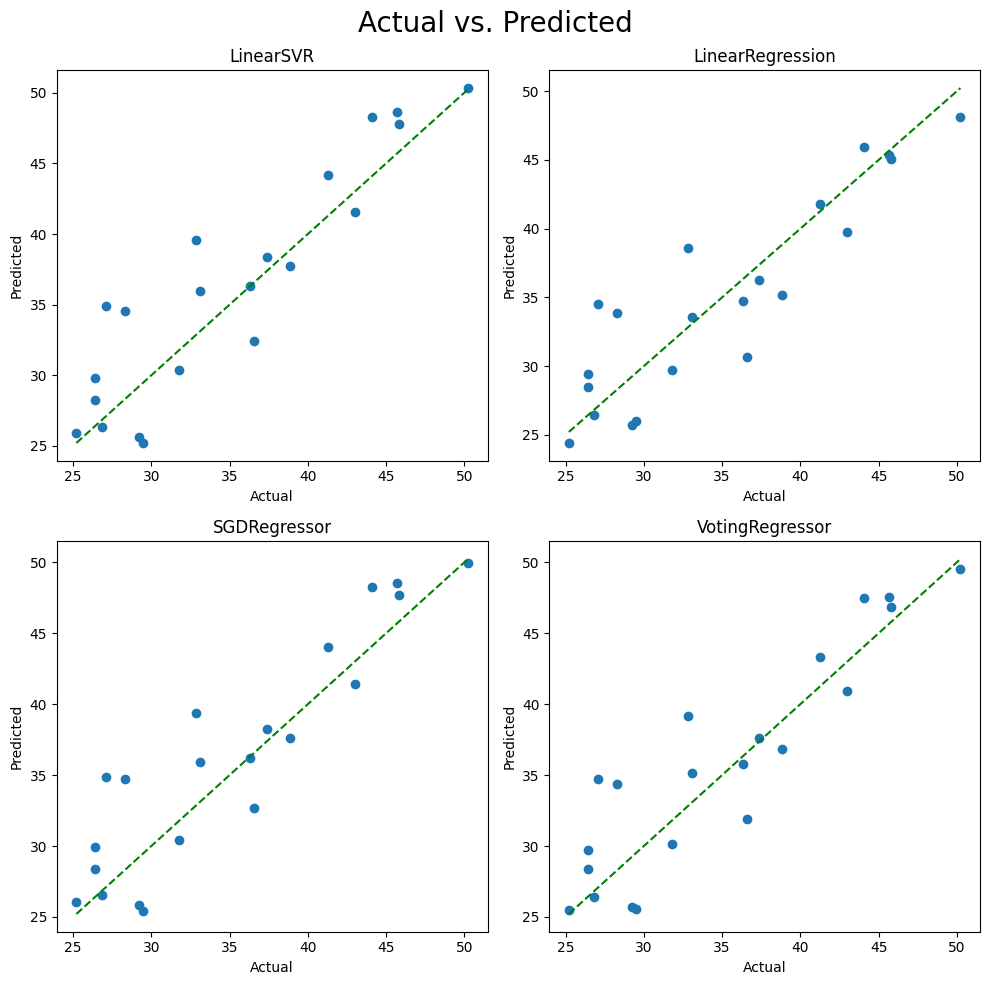

In [121]:
# Create subplots for all 4 regression models
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(y_test, pred_lin_reg)
axs[0, 1].scatter(y_test, pred_lin_svr)
axs[1, 0].scatter(y_test, pred_sgd_reg)
axs[1, 1].scatter(y_test, pred_voting_reg)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
        axs[i, j].set_xlabel('Actual')
        axs[i, j].set_ylabel('Predicted')

axs[0, 0].set_title('LinearSVR')
axs[0, 1].set_title('LinearRegression')
axs[1, 0].set_title('SGDRegressor')
axs[1, 1].set_title('VotingRegressor')

fig.suptitle('Actual vs. Predicted',fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 1])

Looking at the 4 plots above, we can see that the 4 models are quite similar in terms of deviations from the perfect line, but perhaps we can visualise this better by putting them all into a single plot and color coding them.

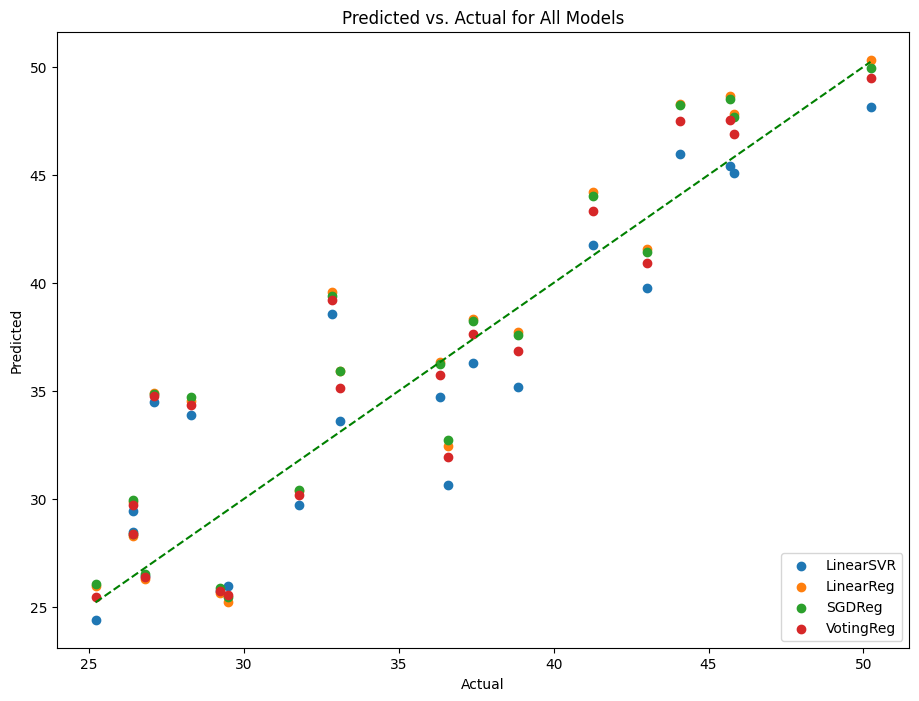

In [122]:
# color coded predicted vs actual
plt.figure(figsize=(11,8))
plt.scatter(y_test, pred_lin_svr, label="LinearSVR")
plt.scatter(y_test, pred_lin_reg, label="LinearReg")
plt.scatter(y_test, pred_sgd_reg, label="SGDReg")
plt.scatter(y_test, pred_voting_reg, label="VotingReg")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
plt.legend(loc="lower right")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual for All Models')
plt.show()

We can observe that all 4 models, looking at the predicted vs actual plots, as well as the test RMSE from above, generally all perform quite close to each other. The plot above shows us that the variation between the predicted scores for each of the instances do not vary greatly, as suspected in the previous plot.

The green diagonal 45 degree dotted line indicates a perfect prediction for any points that fall on that line, and it seems like the models could be improved futher to reduce the error between the actual and predicted values. 

**Voting Regressor II - Tuned Base Estimators**

In [140]:
from sklearn.model_selection import GridSearchCV

# define the paramters to be searched for the SVR
grid_params_SVR = {'epsilon':np.arange(0,2,0.1),
               'C':np.arange(0.01,2,0.01)} 

# default values for all the hyperparams
lin_svr = LinearSVR(random_state=5508)
grid_search = GridSearchCV(lin_svr, grid_params_SVR, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
svr_optimal = grid_search.best_params_
svr_optimal, grid_search.best_score_

({'C': 1.99, 'epsilon': 0.6000000000000001}, 0.8326500723853091)

In [158]:
# define the paramters to be searched for the SGD Regression
grid_params_SGR = {'eta0':np.arange(0.01,0.2,0.01)} 

lin_sgd = SGDRegressor(random_state=5508)
grid_search = GridSearchCV(lin_sgd, grid_params_SGR, cv=3)
grid_search.fit(X_train_scaled, y_train)

sgr_optimal = grid_search.best_params_
sgr_optimal, grid_search.best_score_

({'eta0': 0.19}, 0.8780935667942863)

Tuned Base Estimators with Optimal Hyperparameters:

- SVR Optimal Hyperparameters: epsilon = 0.6, C (regularization parameter) = 1.99
- Linear Regression OLS, no hyperparameters, retain previous model
- Stochastic GD Regression: eta0 (learning rate) = 0.19

In [159]:
# call the regression models, then put them into the voting regressor
lin_svr = LinearSVR(C=svr_optimal['C'], epsilon=svr_optimal['epsilon'],random_state=5508)
lin_reg = LinearRegression()
sgd_reg = SGDRegressor(eta0=sgr_optimal['eta0'],random_state=5508)

voting_reg = VotingRegressor(estimators=[
    ('Linear SVM', lin_svr),
    ('Linear Regression', lin_reg),
    ('SGD Regression', sgd_reg)
])

In [160]:
np.random.seed(5508)
opt_test_rmse = []
# train the models, get both train and test RMSE
for reg in (lin_svr, lin_reg, sgd_reg, voting_reg):
    reg.fit(X_train_scaled, y_train)
    y_pred_train = reg.predict(X_train_scaled)
    y_pred_test = reg.predict(X_test_scaled)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    opt_test_rmse.append(rmse_test)
    print(f'{reg.__class__.__name__} - RMSE train: {rmse_train}, RMSE test: {rmse_test}')

LinearSVR - RMSE train: 2.607304214908252, RMSE test: 3.2672120590650993
LinearRegression - RMSE train: 2.3520029517363343, RMSE test: 3.534364825114908
SGDRegressor - RMSE train: 2.473515621685942, RMSE test: 3.3320893687724022
VotingRegressor - RMSE train: 2.3900978717429946, RMSE test: 3.2968933217090877


Looking at the RMSE for all the 4 models, we can see that the Linear SVR has teh best test RMSE compared to the rest, doing better than the Voting Regressor, which might be pulled down because of a worse model in the Linear Regression model.

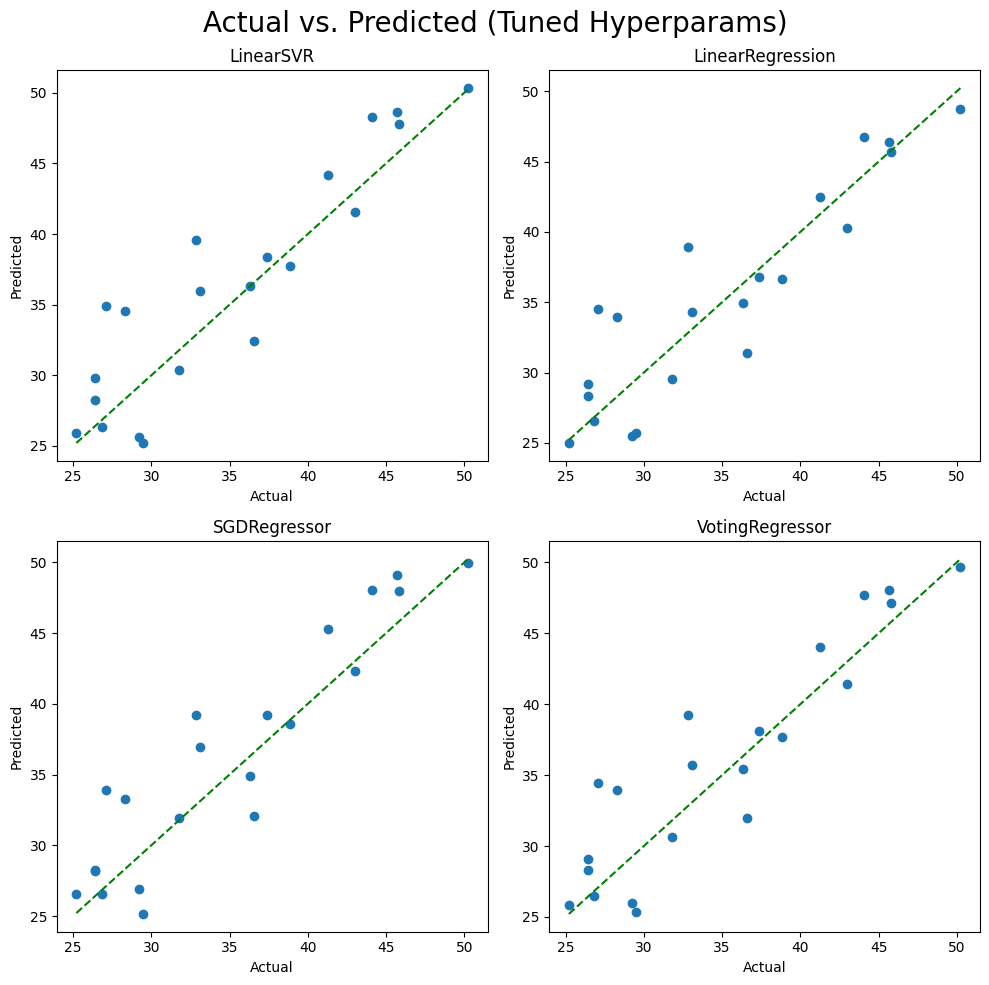

In [161]:
# Create subplots for all 4 regression models
# get predicted values for all 4 models
pred_lin_svr = lin_svr.predict(X_test_scaled)
pred_lin_reg = lin_reg.predict(X_test_scaled)
pred_sgd_reg = sgd_reg.predict(X_test_scaled)
pred_voting_reg = voting_reg.predict(X_test_scaled)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(y_test, pred_lin_reg)
axs[0, 1].scatter(y_test, pred_lin_svr)
axs[1, 0].scatter(y_test, pred_sgd_reg)
axs[1, 1].scatter(y_test, pred_voting_reg)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
        axs[i, j].set_xlabel('Actual')
        axs[i, j].set_ylabel('Predicted')

axs[0, 0].set_title('LinearSVR')
axs[0, 1].set_title('LinearRegression')
axs[1, 0].set_title('SGDRegressor')
axs[1, 1].set_title('VotingRegressor')

fig.suptitle('Actual vs. Predicted (Tuned Hyperparams)',fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 1])

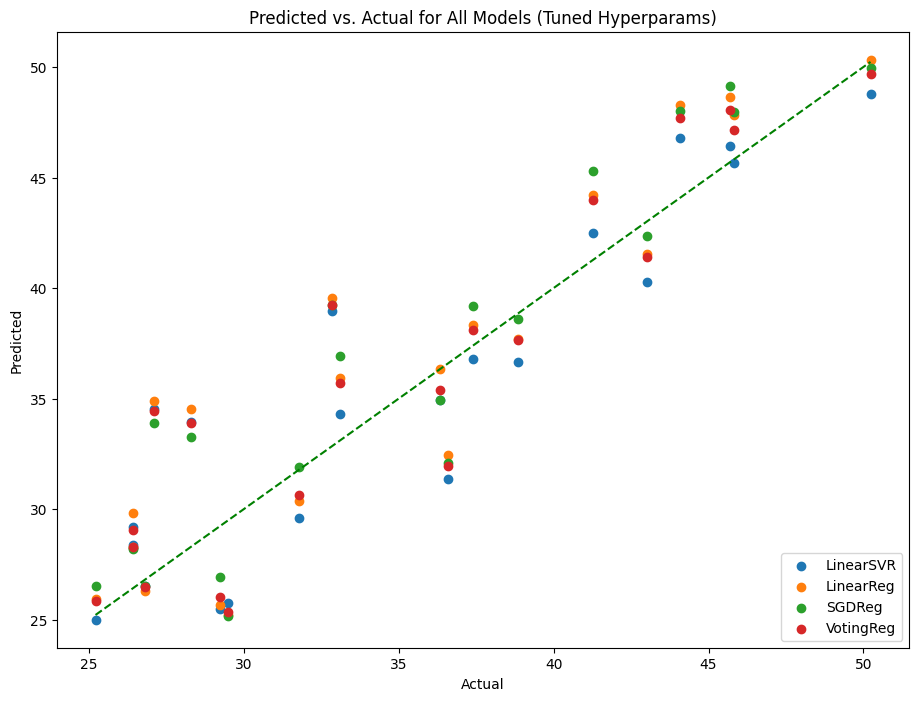

In [162]:
# color coded predicted vs actual
plt.figure(figsize=(11,8))
plt.scatter(y_test, pred_lin_svr, label="LinearSVR")
plt.scatter(y_test, pred_lin_reg, label="LinearReg")
plt.scatter(y_test, pred_sgd_reg, label="SGDReg")
plt.scatter(y_test, pred_voting_reg, label="VotingReg")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
plt.legend(loc="lower right")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual for All Models (Tuned Hyperparams)')
plt.show()

In [163]:
pd.DataFrame([base_test_rsme, opt_test_rmse], columns=['SVR','LR','SGD','Voting'], index=['Base Test RMSE','Optimal Test RMSE'])

SVR        LR       SGD    Voting
Base Test RMSE     3.339646  3.534365  3.487518  3.360461
Optimal Test RMSE  3.267212  3.534365  3.332089  3.296893

In the table above, we can see that the test RMSE scores, are better for all models with tuned hyperparameters compared to the base ones. 

For the SVR, the larger C lowers the regularisation on the predictors, allowing the model to capture more features and patterns in the data. A larger epsilon which is a wider margin on the regression line, allows the SVR to capture more instances. 

## 3. Abalone Dataset

In [164]:
# remember to change to the same directory
abalone = pd.read_csv("../datasets/abalone.data", header=None)
abalone

0      1      2      3       4       5       6       7   8
0     M  0.455  0.365  0.095  0.5140  0.2245  0.1010  0.1500  15
1     M  0.350  0.265  0.090  0.2255  0.0995  0.0485  0.0700   7
2     F  0.530  0.420  0.135  0.6770  0.2565  0.1415  0.2100   9
3     M  0.440  0.365  0.125  0.5160  0.2155  0.1140  0.1550  10
4     I  0.330  0.255  0.080  0.2050  0.0895  0.0395  0.0550   7
...  ..    ...    ...    ...     ...     ...     ...     ...  ..
4172  F  0.565  0.450  0.165  0.8870  0.3700  0.2390  0.2490  11
4173  M  0.590  0.440  0.135  0.9660  0.4390  0.2145  0.2605  10
4174  M  0.600  0.475  0.205  1.1760  0.5255  0.2875  0.3080   9
4175  F  0.625  0.485  0.150  1.0945  0.5310  0.2610  0.2960  10
4176  M  0.710  0.555  0.195  1.9485  0.9455  0.3765  0.4950  12

[4177 rows x 9 columns]

We can observe from the dataframe above that there are not column name attributes, but we can find them to give us a better understanding of the dataset from the UCI data source.

The abalone dataset predicts the age of the abalone (given the number of rings), from the 8 physical measurements (covariates) listed below:

Some information about the Abalone dataset and it's attributes (in order from 0-8):
- Sex (M,F,I)
- Length
- Diameter
- Height
- Whole Weight
- Shucked Weight
- Viscera Weight
- Shell Weight
- Rings (Prediction Variable)

In [165]:
# change variable names
abalone_names = ['Sex','Length','Diameter','Height','Whole Weight','Shucked Weight','Viscera Weight','Shell Weight','Rings']
abalone.columns = abalone_names

Likewise, before we do any modelling, we first want to check if the dataset is complete or have any invalid values. From the cell below,

In [166]:
# Check for any missing values in the dataset
null_count = np.array(abalone.isnull().sum())
na_counts = np.array(abalone.isna().sum())
pd.DataFrame(np.vstack((null_count, na_counts)), columns=abalone.columns, index=['null_count','na_counts'])

Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  \
null_count    0       0         0       0             0               0   
na_counts     0       0         0       0             0               0   

            Viscera Weight  Shell Weight  Rings  
null_count               0             0      0  
na_counts                0             0      0

Great, no null or na values. Let's look at some summary statistics.

In [167]:
abalone.describe()

Length     Diameter       Height  Whole Weight  Shucked Weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera Weight  Shell Weight        Rings  
count     4177.000000   4177.000000  4177.000000  
mean         0.180594      0.238831     9.933684  
std          0.109614      0.139203     3.224169  
min          0.000500      0.001500     1.000000  
25%          0.093500      0.130000     8.000000  
50%          0.171000      0.234000     9.000000  
75%          0.253000      0.329000    11.000000  
max          0.760000      1.005000    29.000000

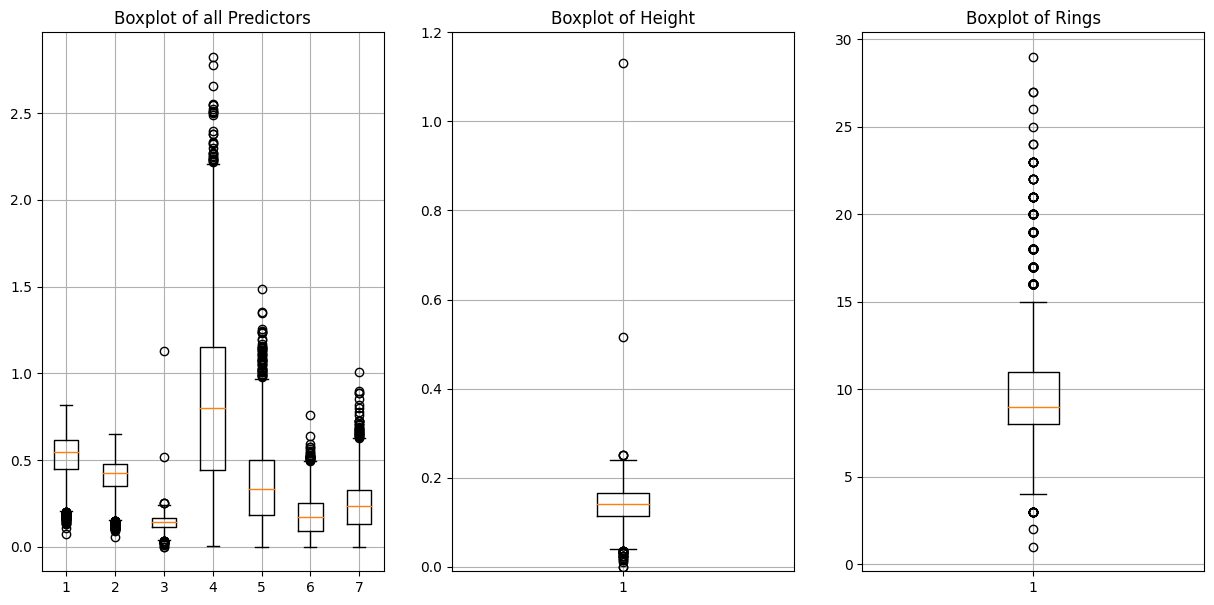

In [168]:
# plot boxplots
fig, ax = plt.subplots(1,3, figsize=(15,7))
ax[0].boxplot(abalone.iloc[:,1:8])
ax[1].boxplot(abalone.iloc[:,3])
ax[2].boxplot(abalone.iloc[:,8])
ax[1].set_ylim(-0.01,1.2)
ax[0].set_title('Boxplot of all Predictors')
ax[1].set_title('Boxplot of Height')
ax[2].set_title('Boxplot of Rings')
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

Looking at the summary statistics above, as well as the boxplot of all the predictors, we observe that all the predictors look okay except for the height. On, on further inspection, there are 2 things we observe.

1. There seem to be an observation(s) that have a height of 0. This value does not make sense as abalone height cannot be 0. Therefore, we may want further investigate these observations and deal with them.
2. There are also observations that are outliers that might need to be removed from the dataset

We can identify them both.

In [169]:
# Instances that are outliers for height
abalone.loc[abalone["Height"] > 0.4]

Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  \
1417   M   0.705     0.565   0.515         2.210          1.1075   
2051   F   0.455     0.355   1.130         0.594          0.3320   

      Viscera Weight  Shell Weight  Rings  
1417          0.4865        0.5120     10  
2051          0.1160        0.1335      8

In [170]:
outliers_index = abalone.loc[abalone["Height"] > 0.4].index
abalone = abalone.drop(outliers_index)
abalone.reset_index(drop=True, inplace=True) # reset the index.

In [171]:
# Find observations that have height 0
abalone.loc[abalone["Height"] == 0]

Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  \
1257   I   0.430      0.34     0.0         0.428          0.2065   
3994   I   0.315      0.23     0.0         0.134          0.0575   

      Viscera Weight  Shell Weight  Rings  
1257          0.0860        0.1150      8  
3994          0.0285        0.3505      6

There are 2 instances where height = 0, and in both cases, the abalone was identified as an infant. We can either impute these values, or remove the data. However, if we want to keep some integrity of the data, perhaps it would be better to impute the height data of these 2 observations. A good imputer might be the KNNImputer.

In [172]:
from sklearn.impute import KNNImputer

abalone.loc[abalone["Height"] == 0, "Height"] = np.nan # set the values of 0 to be nan
# before fitting the imputer, take only the numerical columns
abalone_num = abalone.iloc[:,1:9]


knn_imputer = KNNImputer(n_neighbors=5, weights="uniform") # call the imputer, use 5 neighbours
imputed_ab = pd.DataFrame(knn_imputer.fit_transform(abalone_num))
abalone_imputed = pd.concat([abalone.iloc[:,0],imputed_ab],axis=1)
abalone_imputed.columns = abalone_names
abalone_imputed

Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  \
0      M   0.455     0.365   0.095        0.5140          0.2245   
1      M   0.350     0.265   0.090        0.2255          0.0995   
2      F   0.530     0.420   0.135        0.6770          0.2565   
3      M   0.440     0.365   0.125        0.5160          0.2155   
4      I   0.330     0.255   0.080        0.2050          0.0895   
...   ..     ...       ...     ...           ...             ...   
4170   F   0.565     0.450   0.165        0.8870          0.3700   
4171   M   0.590     0.440   0.135        0.9660          0.4390   
4172   M   0.600     0.475   0.205        1.1760          0.5255   
4173   F   0.625     0.485   0.150        1.0945          0.5310   
4174   M   0.710     0.555   0.195        1.9485          0.9455   

      Viscera Weight  Shell Weight  Rings  
0             0.1010        0.1500   15.0  
1             0.0485        0.0700    7.0  
2             0.1415        0.2100    9.0  
3             0.1140        0.1550   10.0  
4             0.0395        0.0550    7.0  
...              ...           ...    ...  
4170          0.2390        0.2490   11.0  
4171          0.2145        0.2605   10.0  
4172          0.2875        0.3080    9.0  
4173          0.2610        0.2960   10.0  
4174          0.3765        0.4950   12.0  

[4175 rows x 9 columns]

In [173]:
abalone_imputed.iloc[[1257,3994]]

Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  \
1257   I   0.430      0.34   0.111         0.428          0.2065   
3994   I   0.315      0.23   0.082         0.134          0.0575   

      Viscera Weight  Shell Weight  Rings  
1257          0.0860        0.1150    8.0  
3994          0.0285        0.3505    6.0

The two instances that we identified earlier have now been imputed using the KNN imputer, where the height values have now been imputed and looks ok.

Looking at the pairs plot below, we can observe that there are some interesting correlations between the variables, which look to be quite linear. This is apparent for those variables that are related to each other, which are height and diameter, as well as those ones involving weight. The rings dependent variable on all the other variables seem to show no pattern between the pairs. However, we can observe that infant abalones, just like all the other variables have much smaller values compared to the adult (M and F) instances.

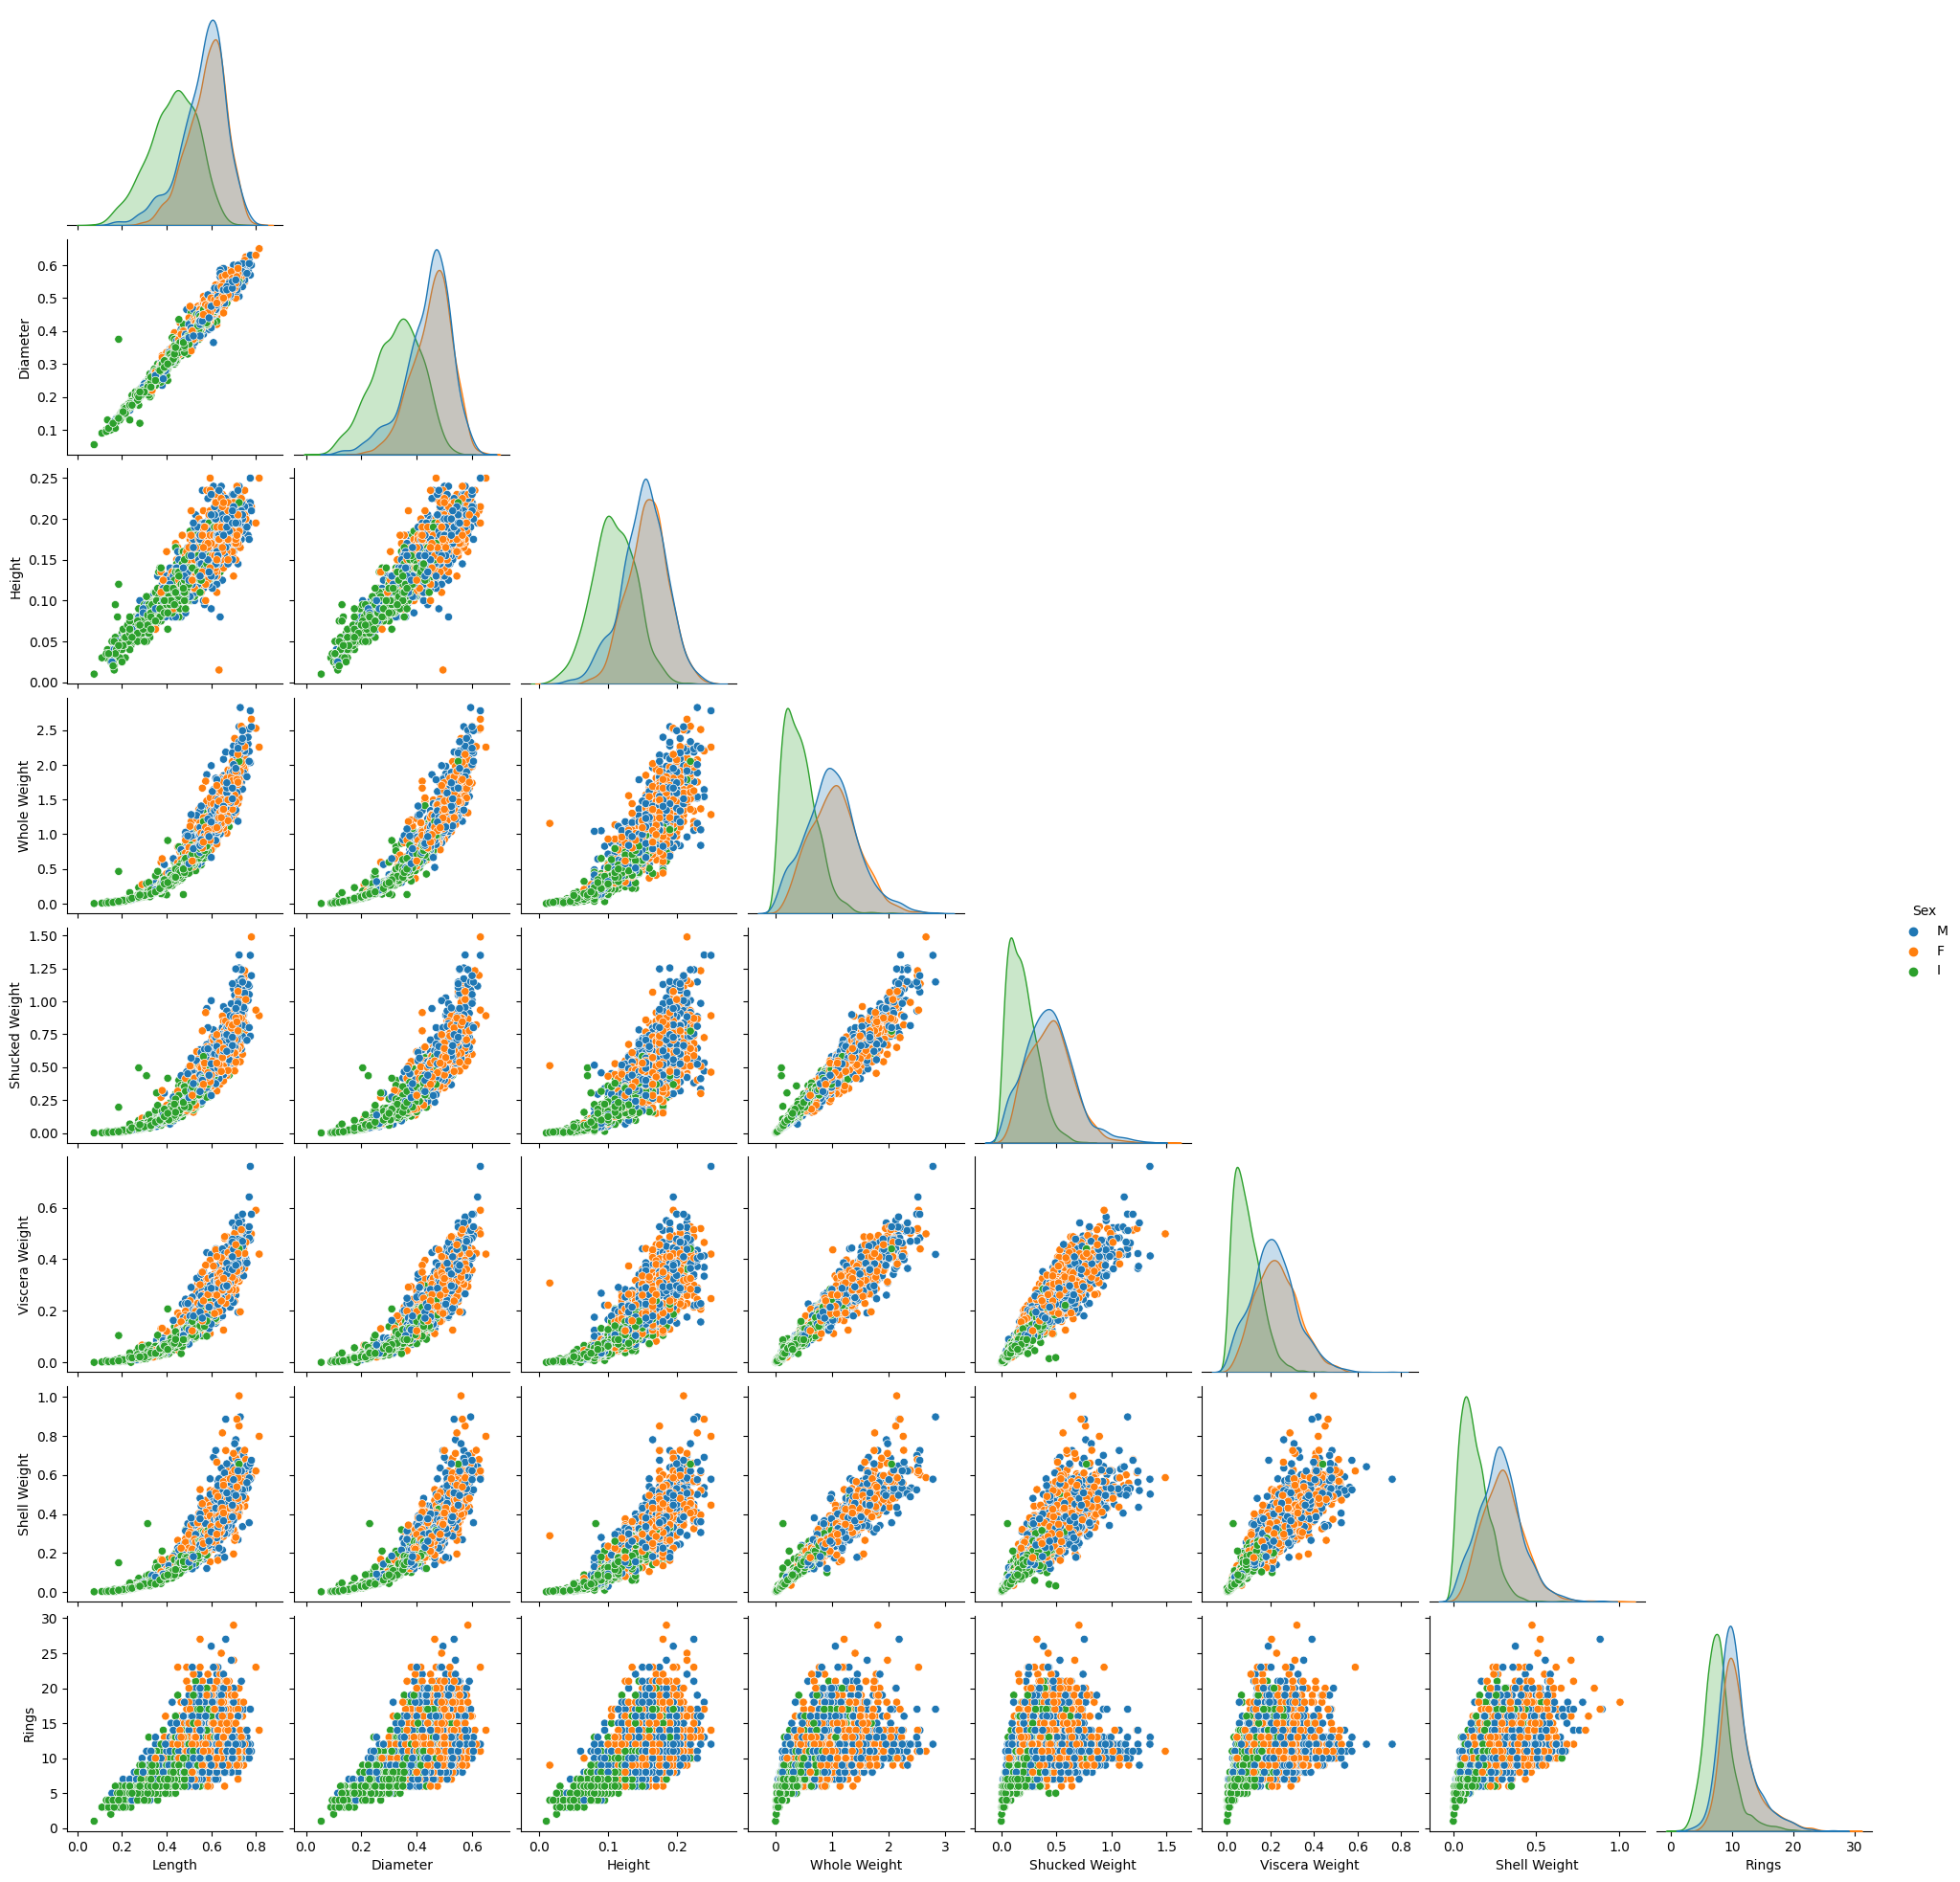

In [174]:
sns.pairplot(abalone_imputed, diag_kind = 'kde', hue='Sex', corner=True)

Using the cleaned data, on removing the outliers and imputed 0 values on height, we might want to convert the sex variable from a string type, to a numerical value. 

- 0 for infant
- 1 for male
- 2 for female

In [175]:
cleaned_abalone = abalone_imputed

In [176]:
sex_int = {'I': 0, 'M': 1, 'F': 2}
# map the sex column to the relevant numerical tags above

cleaned_abalone['Sex'] = abalone_imputed['Sex'].map(sex_int)
cleaned_abalone

Sex  Length  Diameter  Height  Whole Weight  Shucked Weight  \
0       1   0.455     0.365   0.095        0.5140          0.2245   
1       1   0.350     0.265   0.090        0.2255          0.0995   
2       2   0.530     0.420   0.135        0.6770          0.2565   
3       1   0.440     0.365   0.125        0.5160          0.2155   
4       0   0.330     0.255   0.080        0.2050          0.0895   
...   ...     ...       ...     ...           ...             ...   
4170    2   0.565     0.450   0.165        0.8870          0.3700   
4171    1   0.590     0.440   0.135        0.9660          0.4390   
4172    1   0.600     0.475   0.205        1.1760          0.5255   
4173    2   0.625     0.485   0.150        1.0945          0.5310   
4174    1   0.710     0.555   0.195        1.9485          0.9455   

      Viscera Weight  Shell Weight  Rings  
0             0.1010        0.1500   15.0  
1             0.0485        0.0700    7.0  
2             0.1415        0.2100    9.0  
3             0.1140        0.1550   10.0  
4             0.0395        0.0550    7.0  
...              ...           ...    ...  
4170          0.2390        0.2490   11.0  
4171          0.2145        0.2605   10.0  
4172          0.2875        0.3080    9.0  
4173          0.2610        0.2960   10.0  
4174          0.3765        0.4950   12.0  

[4175 rows x 9 columns]

Now, we can split our data into training and test sets for modelling.

### 2. Hyperparameter Tuning and Modelling

In [24]:
from sklearn.model_selection import train_test_split

# split the data into train and test
X = cleaned_abalone.iloc[:,0:8]
y = cleaned_abalone.iloc[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5508)

**Train a Decision Tree Regression using 3 Fold CV**

We can tune the hyperparameter of max_depth to control how deep the tree splits, where the higher the tree depth is, the more prone the tree is to overfitting.

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# create lists to save errors:
training_err, cv_err, test_err = [],[],[]

# First we tune max_depth, keeping all other hyperparameters the same:
for depth in range(2,15):
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=5508)
    tree_reg.fit(X_train, y_train)
    
    # get the score (if the observations were put classed correctly in tree)
    train_err_iter = 1 - tree_reg.score(X_train, y_train)
    test_err_iter = 1 - tree_reg.score(X_test, y_test)
    cv_err_iter = 1 - np.mean(cross_val_score(tree_reg, X_train, y_train, cv=3))
    
    # append all the values to the lists we created
    training_err.append(train_err_iter)
    cv_err.append(cv_err_iter)
    test_err.append(test_err_iter)

Text(0.5, 1.0, 'Error on Max Depth Hyperparameter')

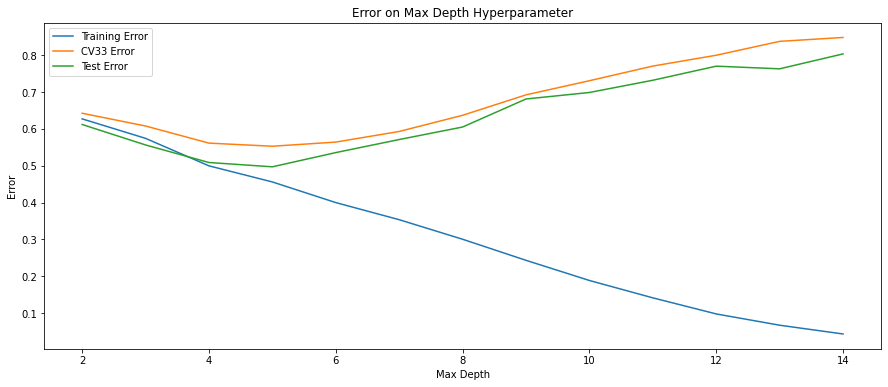

In [26]:
depths = np.arange(2,15) # max depth hyperparams we fitted

plt.figure(figsize=(15,6))
plt.plot(depths, training_err, label="Training Error")
plt.plot(depths, cv_err, label="CV33 Error")
plt.plot(depths, test_err, label="Test Error")
plt.xlabel("Max Depth")
plt.ylabel("Error")
plt.legend()
plt.title("Error on Max Depth Hyperparameter")

Looking at this plot, we can see that the error score of the CV3 and the test error start to bottom out at around tree depth of 5, and then starts to increase as the depth increases. Therefore, perhaps maybe depth 5 would be the best value to pick, for generalisability and to avoid overfitting. 

**Train a Decision Tree Regression using 3 Fold CV, tuning min_samples_leaf**

In the previous section, we have chosen max_depth to be 5, so we will fix that value to train the min_samples_leaf. We understand that perhaps by tuning the min_samples_leaf to a higher value, it will avoid overfitting the tree and improve generalisability. However, we also have to consider underfitting if the value is too small. Therefore, we want to pick a value to improve our DT regression model.

In [27]:
# create lists to save errors:
training_err, cv_err, test_err = [],[],[]

# First we tune max_depth, keeping all other hyperparameters the same:
for min_samp_leaf in range(2,80):
    tree_reg = DecisionTreeRegressor(max_depth=5, min_samples_leaf=min_samp_leaf, random_state=5508)
    tree_reg.fit(X_train, y_train)
    
    # get the score (if the observations were classed correctly in tree)
    train_err_iter = 1 - tree_reg.score(X_train, y_train)
    test_err_iter = 1 - tree_reg.score(X_test, y_test)
    cv_err_iter = 1 - np.mean(cross_val_score(tree_reg, X_train, y_train, cv=3))
    
    # append all the values to the lists we created
    training_err.append(train_err_iter)
    cv_err.append(cv_err_iter)
    test_err.append(test_err_iter)

Text(0.5, 1.0, 'Error on Min Samples Leaf Hyperparameter, with Max Depth=5')

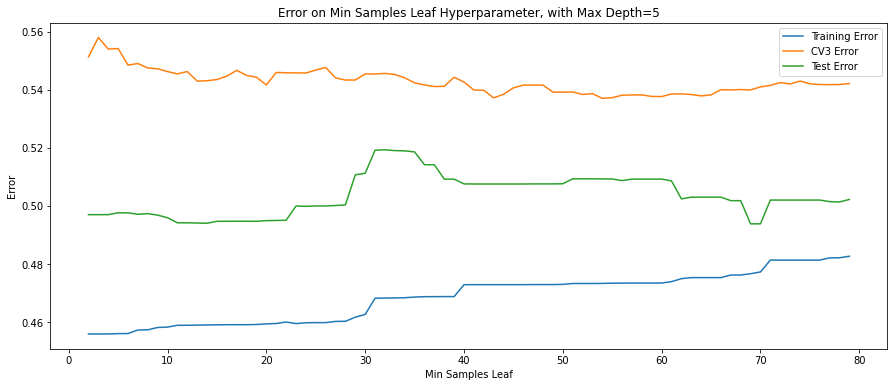

In [28]:
min_samples_leaf = np.arange(2,80) # max depth hyperparams we fitted

plt.figure(figsize=(15,6))
plt.plot(min_samples_leaf, training_err, label="Training Error")
plt.plot(min_samples_leaf, cv_err, label="CV3 Error")
plt.plot(min_samples_leaf, test_err, label="Test Error")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Error")
plt.legend()
plt.title("Error on Min Samples Leaf Hyperparameter, with Max Depth=5")

As expected, we see that the errors starts to rise as the number of samples per leaf increases. Looking at the training and the test error line plots, we can see that there is a spike in the error around the 30 min samples per leaf mark, which could signal overfitting. Therefore, we perhaps would pick a number somewhere around 25.

**Implementing a Random Forest Regressor with 500 estimators**

Keeping the hyperparameters of max_depth and min_samples_leaf to 5 and 8 respectively, we can then implement the random forest regressor and tune the other hyperparameters to find the optimal model.

In [29]:
from sklearn.ensemble import RandomForestRegressor

rand_forest_model = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=25, random_state=5508)
# testing the base model with no other hyperparameter:

In [30]:
def train_test_rmse(model, X_train, y_train, X_test, y_test, option='rmse'):
    model.fit(X_train, y_train) # fit the model first
    train_pred = np.round(model.predict(X_train)) # round up or down to the nearest integer.
    test_pred =  np.round(model.predict(X_test))
    train_rmse = mean_squared_error(y_train, train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, test_pred, squared=False)
    if option == 'rmse':
        return(train_rmse, test_rmse)
    elif option == 'predict':
        return(train_pred, test_pred)
    elif option == 'all':
         return(train_rmse, test_rmse, train_pred, test_pred)
        
base_train_rmse, base_test_rmse = train_test_rmse(rand_forest_model,X_train, y_train, X_test, y_test)
print(f'Base Training RMSE:{base_train_rmse}, Base Test RMSE: {base_test_rmse}')

Base Training RMSE:2.1223165960653962, Base Test RMSE: 2.1731286290225693


**Manually testing with max_samples and Bootstrap**

In the Scikit documentation, the random forest regressor considers many other hyperparamters to tune and vary the trees. We will consider 2 features, bootstrap and max_samples.
- Bootstrap: Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
- max_samples: If bootstrap is True, the number of samples to draw from X to train each base estimator.
    - Should be a float from 0.0 to 1.0

In [31]:
# Using bootstrap and max_samples 
max_samples_range = [0.1, 0.25, 0.5, 0.75, 1] # percentage of the dataset used by bootstrap

for percent in max_samples_range:
    model = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=25, bootstrap=True,
                                  max_samples=percent, random_state=5508)
    train_rmse, test_rmse = train_test_rmse(model, X_train, y_train, X_test, y_test)
    print(f'Bootstrap Size {percent}: Training RMSE:{train_rmse}, Test RMSE: {test_rmse}')

Bootstrap Size 0.1: Training RMSE:2.302699264078828, Test RMSE: 2.2885889874394283
Bootstrap Size 0.25: Training RMSE:2.1804191647329216, Test RMSE: 2.189215265083359
Bootstrap Size 0.5: Training RMSE:2.1427363470542984, Test RMSE: 2.181186777324619
Bootstrap Size 0.75: Training RMSE:2.1283505318605886, Test RMSE: 2.180089692783428
Bootstrap Size 1: Training RMSE:3.217588360725395, Test RMSE: 3.2672069338083496


Looks like all the bootstrap sizes do not have test RMSE scores that does better than the base model, so we still select the base model as our preferred model for the random forest regressor model.

**Manually testing with max_features**

We tune this parameter to control the number of features to consider when looking for the best split. This can be given by an integer. Since we have 8 features, we will try 1-8.

In [32]:
# number of features to test
feature_range = np.arange(1,9)

for n_features in feature_range:
    model = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=25, 
                                  max_features=n_features, random_state=5508)
    train_rmse, test_rmse = train_test_rmse(model, X_train, y_train, X_test, y_test)
    print(f'Feature = {n_features}: Training RMSE:{train_rmse}, Test RMSE: {test_rmse}')

Feature = 1: Training RMSE:2.3663247181922955, Test RMSE: 2.4236342937400153
Feature = 2: Training RMSE:2.268541292138528, Test RMSE: 2.364678950529006
Feature = 3: Training RMSE:2.200107612413692, Test RMSE: 2.3114719793507694
Feature = 4: Training RMSE:2.173038645774982, Test RMSE: 2.266178763513101
Feature = 5: Training RMSE:2.148844108673821, Test RMSE: 2.248160687157194
Feature = 6: Training RMSE:2.130666726399355, Test RMSE: 2.1964884255348975
Feature = 7: Training RMSE:2.1215196314875153, Test RMSE: 2.1884866196096624
Feature = 8: Training RMSE:2.1223165960653962, Test RMSE: 2.1731286290225693


Looking at the data above, we can see that using all features might be the best solution, which is the same as the baseline model.

**Feature Selection**

Feature selection is important as it allows iis to reduce the number of dimensions of our feature space on predictions. If a feature does not contribute in a statistically significant way on our dependent variable, then we can perhaps drop them to improve our model performance and also reduce overfitting.

We can use the feature_selection module to help us identify which predictors can be dropped and for the purposes of this assignment, we use the SelectFromModel algorithm. 

The above algorithm is a "Meta-transformer for selecting features based on importance weights".

In [33]:
from sklearn.feature_selection import SelectFromModel

model_opt = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=25, 
                                  max_features=8, random_state=5508)
model_opt.fit(X_train, y_train)
# Create the selection model to find the best features
selection_model = SelectFromModel(model_opt, threshold=0.05)

In [34]:
# finding the feature importances manually, call from the model itself
features = abalone_names[:-1]
importance = pd.DataFrame({'Features':features,'Importance':model_opt.feature_importances_})
importance

Features  Importance
0             Sex    0.025266
1          Length    0.008255
2        Diameter    0.013984
3          Height    0.012458
4    Whole Weight    0.012783
5  Shucked Weight    0.135061
6  Viscera Weight    0.007165
7    Shell Weight    0.785027

In [35]:
# Identifying the features that have importance values of more than 0.05
importance.loc[importance["Importance"] > 0.05]

Features  Importance
5  Shucked Weight    0.135061
7    Shell Weight    0.785027

**Features kept:**
- Shucked Weight (0.135)
- Shell Weight (0.7850)

**Features removed:**
- Sex
- Length
- Diameter
- Height
- Whole Weight
- Viscera Weight

The importance of shell weight (0.785) on number of rings is huge, compared to the shucked weight of 0.135. Therefore the total importance value that is retained is:

In [36]:
imp_sum = importance.loc[importance["Importance"] > 0.05].sum()
print(f'Feature Importance Retained: {imp_sum[1]}')

Feature Importance Retained: 0.920088777619321


In [37]:
#We can use the select from model library to fit transform our X train and X test datasets directly.
X_train_selected = selection_model.transform(X_train.values)
X_test_selected = selection_model.transform(X_test.values)

Upon transforming the training and test X data, to include only the features that we have selected. We can train the random forest regressor again to find the best model that gives us best RMSE error.

Text(0.5, 1.0, 'Error on Max Depth Hyperparameter')

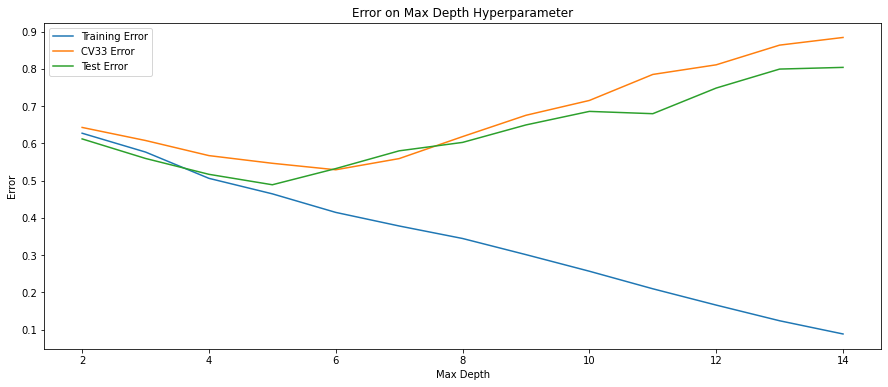

In [38]:
# Start again with the base model, to find the best max_depth
training_err, cv_err, test_err = [],[],[]

# First we tune max_depth, keeping all other hyperparameters the same:
for depth in range(2,15):
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=5508)
    tree_reg.fit(X_train_selected, y_train)
    
    # get the score (if the observations were put classed correctly in tree)
    train_err_iter = 1 - tree_reg.score(X_train_selected, y_train)
    test_err_iter = 1 - tree_reg.score(X_test_selected, y_test)
    cv_err_iter = 1 - np.mean(cross_val_score(tree_reg, X_train_selected, y_train, cv=3))
    
    # append all the values to the lists we created
    training_err.append(train_err_iter)
    cv_err.append(cv_err_iter)
    test_err.append(test_err_iter)
    
depths = np.arange(2,15) # max depth hyperparams we fitted
plt.figure(figsize=(15,6))
plt.plot(depths, training_err, label="Training Error")
plt.plot(depths, cv_err, label="CV33 Error")
plt.plot(depths, test_err, label="Test Error")
plt.xlabel("Max Depth")
plt.ylabel("Error")
plt.legend()
plt.title("Error on Max Depth Hyperparameter")

Like the model with all the predictors, we can still see that the "optimal" max_depth might still be 5.

Text(0.5, 1.0, 'Error on Min Samples Leaf Hyperparameter, with Max Depth=5')

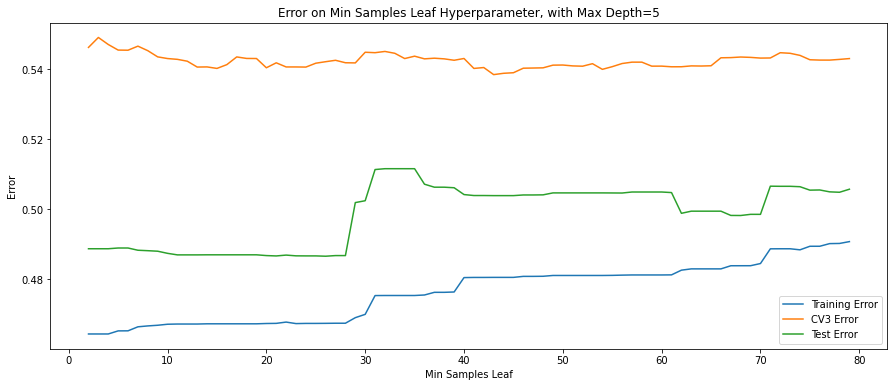

In [39]:
# create lists to save errors:
training_err, cv_err, test_err = [],[],[]

# First we tune max_depth, keeping all other hyperparameters the same:
for min_samp_leaf in range(2,80):
    tree_reg = DecisionTreeRegressor(max_depth=5, min_samples_leaf=min_samp_leaf, random_state=5508)
    tree_reg.fit(X_train_selected, y_train)
    
    # get the score (if the observations were classed correctly in tree)
    train_err_iter = 1 - tree_reg.score(X_train_selected, y_train)
    test_err_iter = 1 - tree_reg.score(X_test_selected, y_test)
    cv_err_iter = 1 - np.mean(cross_val_score(tree_reg, X_train_selected, y_train, cv=3))
    
    # append all the values to the lists we created
    training_err.append(train_err_iter)
    cv_err.append(cv_err_iter)
    test_err.append(test_err_iter)

min_samples_leaf = np.arange(2,80) # max depth hyperparams we fitted
plt.figure(figsize=(15,6))
plt.plot(min_samples_leaf, training_err, label="Training Error")
plt.plot(min_samples_leaf, cv_err, label="CV3 Error")
plt.plot(min_samples_leaf, test_err, label="Test Error")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Error")
plt.legend()
plt.title("Error on Min Samples Leaf Hyperparameter, with Max Depth=5")

Likewise, we try to find the best hyperparameters for max_depth and min_samples_leaf, where looking at the 2 graphs above, it looks like we retain the 2 selected values, 5 and 25 respectively.

In [40]:
# Training the base model again:
rand_forest_model = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=25, random_state=5508)
base_train_rmse, base_test_rmse = train_test_rmse(rand_forest_model,X_train_selected, y_train, X_test_selected, y_test)
print(f'Base Training RMSE:{base_train_rmse}, Base Test RMSE: {base_test_rmse}')

Base Training RMSE:2.1675192725945416, Base Test RMSE: 2.1935820551907477


Comparing the base training RMSE and the base test RMSE from the full features to the reduced features, we can see that the RMSE is higher for the reduced! However, the increase is not very significant as can perhaps attribute this to the huge importance of shell weight.

Additionally, we can also try to find the best max samples and number of features.

In [41]:
# Using bootstrap and max_samples 
max_samples_range = [0.1, 0.25, 0.5, 0.75, 1] # percentage of the dataset used by bootstrap

for percent in max_samples_range:
    model = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=25, bootstrap=True,
                                  max_samples=percent, random_state=5508)
    train_rmse, test_rmse = train_test_rmse(model, X_train_selected, y_train, X_test_selected, y_test)
    print(f'Bootstrap Size {percent}: Training RMSE: {train_rmse}, Test RMSE: {test_rmse}')

Bootstrap Size 0.1: Training RMSE: 2.306795998572574, Test RMSE: 2.2837055424867474
Bootstrap Size 0.25: Training RMSE: 2.2165082181095137, Test RMSE: 2.188122205883115
Bootstrap Size 0.5: Training RMSE: 2.1857125488294393, Test RMSE: 2.193945562038084
Bootstrap Size 0.75: Training RMSE: 2.1718061208084527, Test RMSE: 2.196125339587209
Bootstrap Size 1: Training RMSE: 3.217588360725395, Test RMSE: 3.2672069338083496


The bootstrap size of 0.25 max_samples give us a slightly better RMSE for the test set. We can then fix this value to then find the max_features hyperparameters, and find that using all features return the best RMSE value.

In [42]:
# number of features to test
feature_range = np.arange(1,3)

for n_features in feature_range:
    model = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=25, 
                                  max_features=n_features, random_state=5508, bootstrap=True,
                                  max_samples=0.25)
    train_rmse, test_rmse = train_test_rmse(model, X_train_selected, y_train, X_test_selected, y_test)
    print(f'Feature = {n_features}: Training RMSE: {train_rmse}, Test RMSE: {test_rmse}')

Feature = 1: Training RMSE: 2.304045263710461, Test RMSE: 2.300752251990612
Feature = 2: Training RMSE: 2.2165082181095137, Test RMSE: 2.188122205883115


**Comparing the Performance of the 2 Random Forest Regressors**

In [43]:
model_opt = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=25, 
                                  max_features=8, random_state=5508)
model_selected = RandomForestRegressor(n_estimators=500, max_depth=5, min_samples_leaf=25, bootstrap=True,
                                  max_samples=0.25, random_state=5508)
# fit the 2 models
model_opt.fit(X_train, y_train)
model_selected.fit(X_train_selected, y_train)

RandomForestRegressor(max_depth=5, max_samples=0.25, min_samples_leaf=25,
                      n_estimators=500, random_state=5508)

In [44]:
# get the predictions of the models and then round to the nearest integer.
pred_test = np.round(model_opt.predict(X_test))
pred_test_selected = np.round(model_selected.predict(X_test_selected))

forest_error = pd.DataFrame({'Full Random Forest Error': np.abs(y_test-pred_test),
              'Selected Random Forest Error':np.abs(y_test-pred_test_selected),
              'Truth Rings': y_test})
forest_error

Full Random Forest Error  Selected Random Forest Error  Truth Rings
2203                       0.0                           0.0          6.0
3053                       1.0                           1.0         11.0
1796                       2.0                           2.0          8.0
656                        4.0                           4.0         17.0
3513                       0.0                           0.0         12.0
...                        ...                           ...          ...
3396                       0.0                           1.0          9.0
2680                       0.0                           0.0         10.0
3116                       2.0                           2.0          8.0
3388                       0.0                           0.0         10.0
587                        2.0                           2.0         13.0

[627 rows x 3 columns]

In [45]:
ring_avg_errors = forest_error.groupby('Truth Rings')[['Full Random Forest Error', 'Selected Random Forest Error']].mean()
ring_avg_errors

Full Random Forest Error  Selected Random Forest Error
Truth Rings                                                        
3.0                          1.000000                      2.000000
4.0                          0.666667                      1.166667
5.0                          1.285714                      1.000000
6.0                          1.311111                      1.466667
7.0                          0.981818                      1.181818
8.0                          1.294118                      1.274510
9.0                          1.311111                      1.288889
10.0                         0.966292                      0.977528
11.0                         0.861111                      0.819444
12.0                         1.060606                      1.181818
13.0                         1.685714                      1.685714
14.0                         2.476190                      2.333333
15.0                         2.538462                      2.461538
16.0                         3.833333                      4.333333
17.0                         4.571429                      4.714286
18.0                         5.600000                      5.600000
19.0                         6.625000                      6.250000
20.0                         5.000000                      5.500000
21.0                         6.000000                      7.000000
22.0                         8.000000                      8.500000
23.0                        10.500000                     10.500000

Text(0.5, 1.0, 'Average Error on Rings')

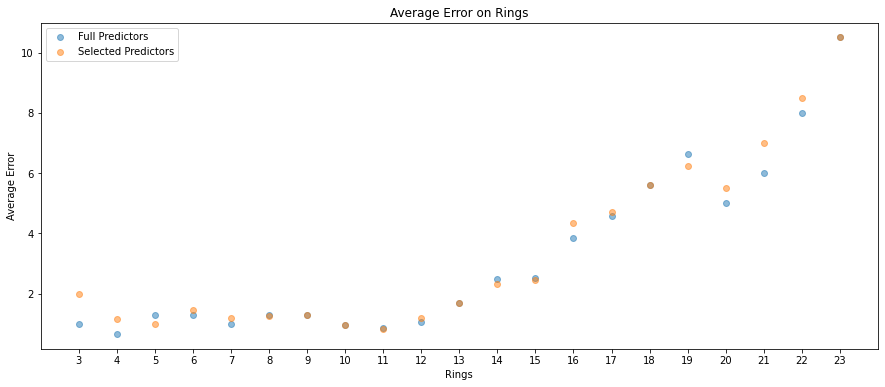

In [46]:
rings = np.arange(3,24,1)
plt.figure(figsize=(15,6))
plt.scatter(rings,ring_avg_errors['Full Random Forest Error'], alpha=0.5, label='Full Predictors')
plt.scatter(rings,ring_avg_errors['Selected Random Forest Error'], alpha=0.5, label='Selected Predictors')
plt.xlabel("Rings")
plt.ylabel("Average Error")
plt.xticks(rings)
plt.legend()
plt.title("Average Error on Rings")

From the above plot and the Ring average error data above, we can observe that bigger ring values tend to have larger ring values. To test the hypothesis if the larger error is due to the number of training instances of larger ring values, we can create a table to get the counts of observations in each ring category. 

Upon observation of the counts below, there is a good chance that the high error in larger ring size observations are due to the fact that there are minimal number of observations in those categories compared to the smaller ones.

In [47]:
pd.DataFrame({'Counts':y_train.value_counts().sort_index()}).T

1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  ...  19.0  \
Counts     1     1    14    45    94   214   336   465   599   544  ...    24   

        20.0  21.0  22.0  23.0  24.0  25.0  26.0  27.0  29.0  
Counts    24    13     4     7     2     1     1     2     1  

[1 rows x 28 columns]

**Bagging Regressor**

In this section, we implement a bagging regressor with 500 SVM regressors as the base estimators. An important step is to scale the data before application of any Support Vector models.

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
std_scaler = StandardScaler() # call the scaler function

num_pipeline = Pipeline([ # pipeline for scaling the data
    ('std_scaler', StandardScaler())
])

X_train_scaled = pd.DataFrame(num_pipeline.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(num_pipeline.fit_transform(X_test), columns=X_train.columns)

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# SVR Base Model
svr_model = SVR()
svr_base_train_rmse, svr_base_test_rmse = train_test_rmse(svr_model, X_train_scaled, y_train, X_test_scaled, y_test)
print(f'Base Model SVR: Training RMSE: {svr_base_train_rmse}, Test RMSE: {svr_base_test_rmse}')

Base Model SVR: Training RMSE: 2.1659583151052084, Test RMSE: 2.149885943341644


In [304]:
# Manually find the optimal hyperparams, starting with the degree of polynomial.
poly_degree = np.arange(1,8)

for degree in poly_degree:
    svr_model_deg = SVR(kernel='poly',degree=degree)
    svr_base_train_rmse, svr_base_test_rmse = train_test_rmse(svr_model_deg, 
                                                              X_train_scaled, y_train, 
                                                              X_test_scaled, y_test)
    print(f'Degree {degree} SVR - Training RMSE: {svr_base_train_rmse}, Test RMSE: {svr_base_test_rmse}')

Degree 1 SVR - Training RMSE: 2.2851907920415675, Test RMSE: 2.2962419891481978
Degree 2 SVR - Training RMSE: 2.7341322468343146, Test RMSE: 2.8086219497786296
Degree 3 SVR - Training RMSE: 2.5048431104346176, Test RMSE: 2.5083592303950675
Degree 4 SVR - Training RMSE: 2.806820489928631, Test RMSE: 2.9458158362309135
Degree 5 SVR - Training RMSE: 2.5597152286651346, Test RMSE: 2.6047435565167083
Degree 6 SVR - Training RMSE: 2.7529322278588273, Test RMSE: 2.9973406607662425
Degree 7 SVR - Training RMSE: 2.5398181898375203, Test RMSE: 2.7564626107389727


We observe that using a polynomial kermel for the SVR might not be the best, compared to using a Gaussian RBF. Therefore, we retain using the base SVR for now. Also, we might want to find the best hyperparamters for C and epsilon in the SVR.

In [52]:
from sklearn.model_selection import GridSearchCV

# define the paramters to be searched for the SVR
grid_params_SVR = {'epsilon':np.arange(0,2,0.1),
               'C':np.arange(0.1,2,0.1)} 

# default values for all the hyperparams
svr_model_base = SVR()
grid_search = GridSearchCV(svr_model_base, grid_params_SVR, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
svr_optimal = grid_search.best_params_
svr_optimal, grid_search.best_score_

({'C': 1.9000000000000001, 'epsilon': 1.6}, 0.5535622895076475)

In [54]:
svr_model_opt =  SVR(C=1.9000000000000001, epsilon=1.6)
svr_opt_train_rmse, svr_opt_test_rmse = train_test_rmse(svr_model_opt, X_train_scaled, y_train, X_test_scaled, y_test)
print(f'Base Model SVR: Training RMSE: {svr_base_train_rmse}, Test RMSE: {svr_base_test_rmse}')

Base Model SVR: Training RMSE: 2.1659583151052084, Test RMSE: 2.149885943341644


Looks like we don't have an improvement on the test or training RMSE score, so the base model might be the most generalised model, and we retain that.

**Implementing a Bagging Regressor**

In this part, we implement a bagging regressor, based on the optimal SVR hyperparameters that we fit earlier.

In [55]:
# Attach the bagging regressor first
from sklearn.ensemble import BaggingRegressor

# using all predictors
bag_reg = BaggingRegressor(estimator=SVR(), n_estimators=500, random_state=5508,
                          bootstrap=True, max_samples=0.25, max_features=8, n_jobs=-1)
bag_train_rmse, bag_test_rmse, bag_train_pred, bag_test_pred = train_test_rmse(bag_reg, 
                                                                  X_train_scaled, 
                                                                  y_train, 
                                                                  X_test_scaled, 
                                                                  y_test, option='all')

In [56]:
print(f'Bagging SVR: Training RMSE: {bag_train_rmse}, Test RMSE: {bag_test_rmse}')

Bagging SVR: Training RMSE: 2.26493539781095, Test RMSE: 2.2495790852081776


The test set RMSE for the n=500 bagging regressor is given above. The diagram below shows us the ground truth vs actual result, with added noise to show where the main bulk of the estimates are. We observe that the model tends to do well for observations with lower number of rings, but does not do well for the observations towards the higher end. This might be attributed to the fact that there are not enough instances of abalones with more rings . 

Text(0.5, 1.0, 'Ground Truth vs. Predicted (Test Set)')

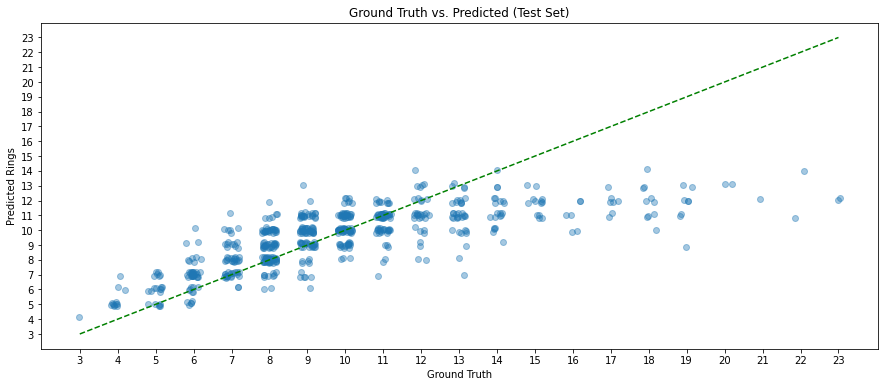

In [57]:
# Bagging Regressor
plt.figure(figsize=(15,6))
jittered_pred = bag_test_pred + np.random.uniform(-0.2, 0.2, len(bag_test_pred))
jittered_truth = y_test + np.random.uniform(-0.2, 0.2, len(y_test))
plt.scatter(jittered_truth, jittered_pred, alpha=0.4, marker='o')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
plt.xlabel("Ground Truth")
plt.ylabel("Predicted Rings")
plt.xticks(rings)
plt.yticks(rings)
plt.title("Ground Truth vs. Predicted (Test Set)")

Comparing this with the Random forest regressor, which seems to do slightly better in predicting the observations with more rings. If we compare the test RMSE however, the Bagging SVR (2.25) and the Random Forest (2.17) do not differ much, but might be more consistent with our visuals of estimating the instances of more rings better.

Text(0.5, 1.0, 'Ground Truth vs. Predicted (Test Set)')

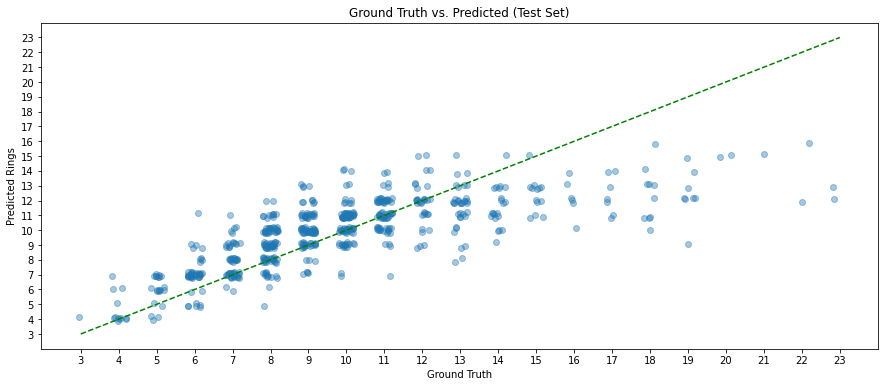

In [348]:
# for the Random Forest Regressor
plt.figure(figsize=(15,6))
jittered_pred = pred_test + np.random.uniform(-0.2, 0.2, len(pred_test))
jittered_truth = y_test + np.random.uniform(-0.2, 0.2, len(y_test))
plt.scatter(jittered_truth, jittered_pred, alpha=0.4, marker='o')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
plt.xlabel("Ground Truth")
plt.ylabel("Predicted Rings")
plt.xticks(rings)
plt.yticks(rings)
plt.title("Ground Truth vs. Predicted (Test Set)")

--End--